# Credit Card Fraud Detection with Sample Comparison and Data Visualization  

Matthew Yankovsky (my518)

Roee Shalom (rs2302) 

Professor Gunawardena  

198:210:06 Data Management for Data Science  

### Project Summary:  
This project, *Credit Card Fraud Detection with Sample Comparison and Data Visualization*, explores methods to detect fraudulent transactions within highly imbalanced financial datasets. Fraud detection is a critical challenge in financial systems, where identifying anomalies among legitimate transactions can significantly enhance security and reduce financial losses. Our research question focuses on: **"How can sampling techniques and machine learning models improve fraud detection in highly imbalanced datasets?"**  

### Motivation:  
Both authors share a strong interest in financial data and its applications, motivating the selection of this project. Fraud detection aligns with real-world challenges in the financial sector and offers an opportunity to apply data management and machine learning techniques to derive actionable insights.

### Project Steps:  
1. **Data Exploration and Preprocessing**:  
   The project begins with an exploratory analysis of the dataset, focusing on feature correlations and data imbalances. Key transformations, including feature scaling and outlier removal, are applied to improve the dataset's quality for modeling.  

2. **Sampling Techniques**:  
   To address the extreme imbalance in fraud cases, we apply and compare **undersampling** and **SMOTE (Synthetic Minority Oversampling Technique)**. These methods balance the dataset, ensuring that machine learning models are trained effectively to detect fraudulent transactions.  

3. **Model Training and Evaluation**:  
   We utilize three machine learning models—**Logistic Regression**, **Decision Trees**, and **Random Forests**—to predict fraud. Each model is evaluated on both sampling techniques to assess performance, using metrics such as precision, recall, F1-score, and ROC-AUC.  

4. **Data Visualization**:  
   Visualizations are incorporated throughout the project to illustrate the distribution of features, the effects of preprocessing steps, and the performance of different models.  

### Objective:  
Through this project, we aim to compare sampling techniques and model effectiveness in detecting fraud. Additionally, the project demonstrates how robust data management and visualization practices contribute to improved decision-making in financial data analysis.  


In [56]:
import os
import pandas as pd
import sqlite3
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ignore Warnings
import warnings # Ignore warnings
warnings.filterwarnings("ignore")

# Data Collection (Kaggle) & Feature Engineering With SQL Queries 

Let's first open up the database and explore the dataset with SQL. We can also create some new features. According to Kaggle, the dataset contains transactions made by credit cards in September 2013 by European cardholders.

This dataset presents transactions that occurred over two days, with 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, with the positive class (frauds) accounting for 0.172% of all transactions.

It contains only numerical input variables, which are the result of a PCA transformation. Due to confidentiality issues, the original features and more background information about the data cannot be provided. Features V1, V2, … V28 are the principal components obtained with PCA. The only features not transformed with PCA are 'Time' and 'Amount'. The 'Time' feature contains the seconds elapsed between each transaction and the first transaction in the dataset. The 'Amount' feature is the transaction amount, which can be used for example-dependent cost-sensitive learning. The 'Class' feature is the response variable, taking the value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, it is recommended to measure accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification. We can potentially feature engineer a hours feature to better represent time and a binary flag indicating whether it is a high transaction amount.

In [57]:
# Define the path for the SQLite database
db_path = './Data/creditcard.db'

# Check if the database exists
if not os.path.exists(db_path):
    print("Database not found. Downloading the dataset and creating the database...")
    
    # Download the dataset
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    print("Path to dataset files:", path)
    
    # Construct the file path
    file_path = os.path.join(path, 'creditcard.csv')
    
    # Verify the file exists in the downloaded path
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Dataset not found in the expected location: {file_path}")
    
    # Load the dataset into a DataFrame
    df = pd.read_csv(file_path)
    
    # Connect to the SQLite database (it will be created if it doesn't exist)
    conn = sqlite3.connect(db_path)
    
    # Save the dataset to a table in the database
    df.to_sql('raw_transactions', conn, if_exists='replace', index=False)
    print(f"Dataset saved to database: {db_path}, table name: 'raw_transactions'")
    
    # Close the connection
    conn.close()
else:
    print("Database already exists. Skipping download.")

# Load the dataset from the SQLite database
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM raw_transactions", conn)
print("Dataset loaded successfully from the database!")


Database already exists. Skipping download.
Dataset loaded successfully from the database!


In [58]:
# Query to calculate summary statistics for transaction amounts
query_summary_amount = """
SELECT 
    AVG(Amount) AS AvgAmount, 
    MAX(Amount) AS MaxAmount, 
    MIN(Amount) AS MinAmount,
    COUNT(*) AS TotalTransactions
FROM raw_transactions;
"""

# Display Summary Statistics for Transaction Amounts
summary_amount_stats = pd.read_sql_query(query_summary_amount, conn)
print("Summary Statistics for Transaction Amounts:")
print(summary_amount_stats)

# Determine "high amount" threshold (e.g., 2x the average)
avg_amount = summary_amount_stats['AvgAmount'][0]
high_amount_threshold = avg_amount * 2
print(f"\nA transaction with an amount > {high_amount_threshold:.2f} can be flagged as high.")

Summary Statistics for Transaction Amounts:
   AvgAmount  MaxAmount  MinAmount  TotalTransactions
0  88.349619   25691.16        0.0             284807

A transaction with an amount > 176.70 can be flagged as high.


In [59]:
# Query to calculate time-related statistics
query_summary_time = """
SELECT 
    MAX(Time) AS MaxTime, 
    MIN(Time) AS MinTime,
    (MAX(Time) - MIN(Time)) / 3600.0 AS TotalHours
FROM raw_transactions;
"""

# Execute query and display results
summary_time_stats = pd.read_sql_query(query_summary_time, conn)
print("Summary Statistics for Transaction Time:")
print(summary_time_stats)

# Deduce bank operating hours (assuming an 8-hour day)
total_hours = summary_time_stats['TotalHours'][0]
print(f"\nThe dataset spans approximately {total_hours:.2f} hours.")
print("Typical banking hours (e.g., 9 AM to 5 PM) for feature engineering.")

Summary Statistics for Transaction Time:
    MaxTime  MinTime  TotalHours
0  172792.0      0.0   47.997778

The dataset spans approximately 48.00 hours.
Typical banking hours (e.g., 9 AM to 5 PM) for feature engineering.


In [60]:
# Calculate the threshold for high transaction amounts (2x average)
query_high_amount_flag = """
CREATE TABLE IF NOT EXISTS processed_transactions AS
SELECT *,
       CASE
           WHEN Amount > (SELECT AVG(Amount) * 2 FROM raw_transactions) THEN 1
           ELSE 0
       END AS IsHighAmount
FROM raw_transactions;
"""

# Execute the query
conn.execute(query_high_amount_flag)
print("High transaction amount feature (IsHighAmount) added to the processed_transactions table.")

High transaction amount feature (IsHighAmount) added to the processed_transactions table.


In [61]:
# Add the Hour column to the processed_transactions table
query_add_hour = """
ALTER TABLE processed_transactions ADD COLUMN Hour INTEGER;
"""
try:
    conn.execute(query_add_hour)
    print("Hour column added to the table.")
except sqlite3.OperationalError as e:
    print(f"Error adding Hour column: {e}")

# Populate the Hour column with calculated values
query_update_hour = """
UPDATE processed_transactions
SET Hour = CAST(Time / 3600 AS INTEGER);
"""
conn.execute(query_update_hour)
print("Hour feature populated in the table.")

Error adding Hour column: duplicate column name: Hour
Hour feature populated in the table.


In [62]:
# Load the final processed_transactions table into pandas
data_df = pd.read_sql_query("SELECT * FROM processed_transactions", conn)

# Close the connection after loading
conn.close()
print("Database connection closed.")

Database connection closed.


# Exploratory Data Analysis (EDA)

Lets start exploring our dataset:

1. **Dataset Overview**: Display column names, check for missing values, and identify duplicates.
2. **Class Distribution**: Analyze the imbalance between fraudulent and non-fraudulent transactions.
3. **Transaction Patterns Over Time**: Investigate the distribution of fraudulent transactions across the 48-hour time period.

Fraudulent transactions are evenly distributed over time, even during low-activity periods like nighttime. This suggests that anomalies are not tied to specific hours, emphasizing the need for robust detection methods.

In [63]:
# List of column names
columns = data_df.columns.tolist()

# Print the column names in a more readable format
print("List of Column Names:")
print(", ".join(columns))

# Display the first few rows of the DataFrame
print("\nFirst Few Rows of the DataFrame:")
print(data_df.head())


List of Column Names:
Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount, Class, IsHighAmount, Hour

First Few Rows of the DataFrame:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V23       V24       V25       V26       V27  \
0  0.098698  0.363787  ... -0.110474  0.066928  0.128539 -0.189115  0.133558   
1  0.085102 -0.255425  ...  0.101288 -0.339846  0.167170  0.125895 -0.008983   
2  0.247676 -1.514654  ...  0.909412 -0.689281

In [64]:
tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


In [65]:
# Check for missing values and duplicates
print(f"Missing Values: {data_df.isnull().sum().max()}")
print(f"Duplicate Rows: {data_df.duplicated().sum()}")

Missing Values: 0
Duplicate Rows: 1081


Text(0, 0.5, 'Count')

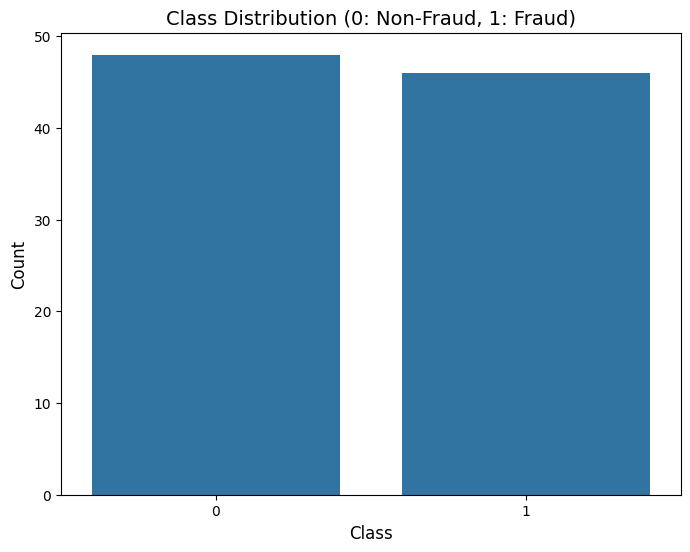

In [66]:
# Class distribution
class_counts = df['Class'].value_counts()
class_percentages = (class_counts / len(df)) * 100

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

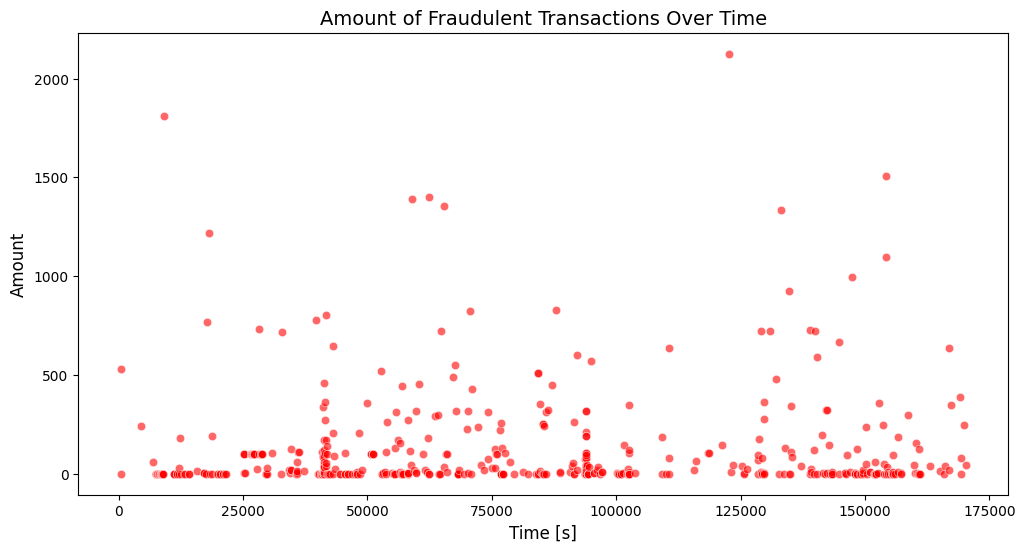

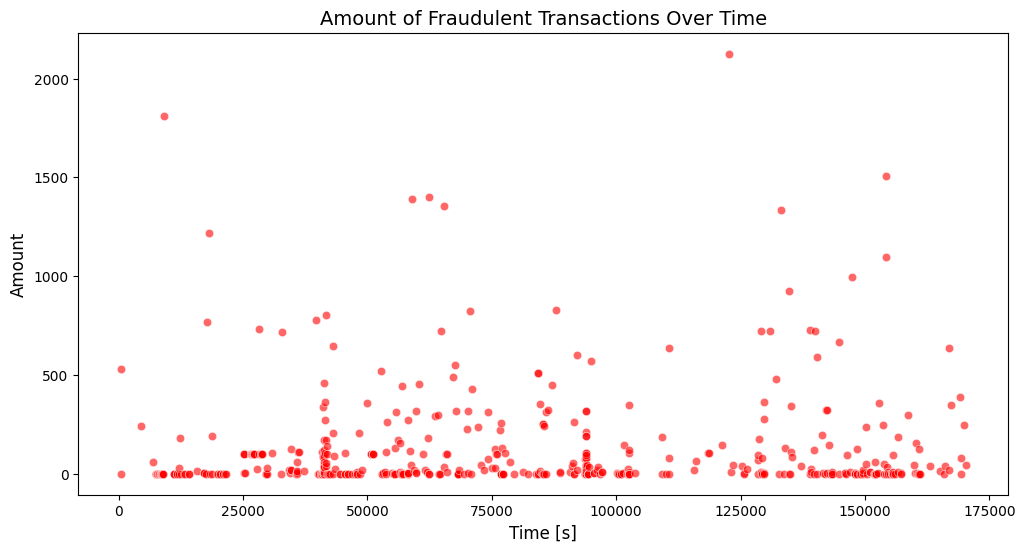

In [67]:
# Time is shown in seconds from the start of the time period (total 48h, over 2 days).
# Plot the distribution of transactions over 48 hours
fraud = data_df[data_df['Class'] == 1]

plt.figure(figsize=(12, 6))
sns.scatterplot(x=fraud['Time'], y=fraud['Amount'], color="red", alpha=0.6)
plt.title('Amount of Fraudulent Transactions Over Time', fontsize=14)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x=fraud['Time'], y=fraud['Amount'], color="red", alpha=0.6)
plt.title('Amount of Fraudulent Transactions Over Time', fontsize=14)
plt.xlabel('Time [s]', fontsize=12)
plt.ylabel('Amount', fontsize=12)
plt.show()

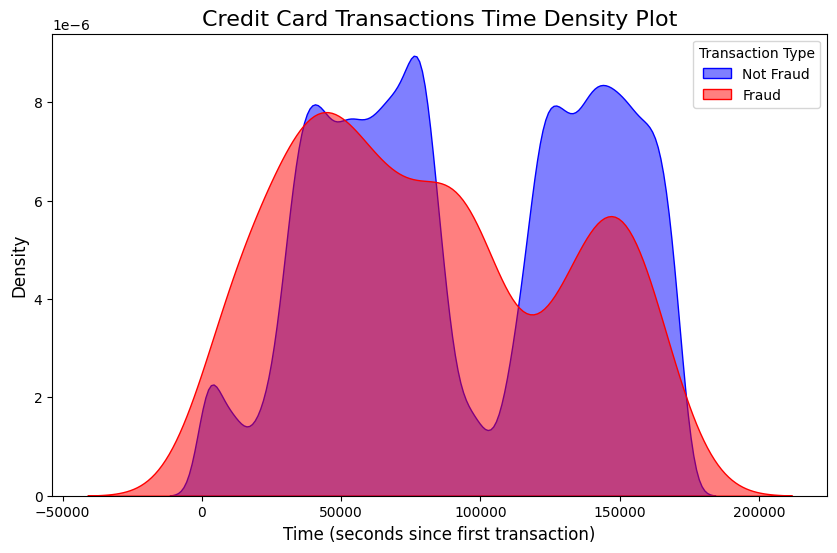

In [68]:
# Separate 'Time' by class
class_0 = data_df.loc[data_df['Class'] == 0]['Time']
class_1 = data_df.loc[data_df['Class'] == 1]['Time']

# Create the density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(class_0, label='Not Fraud', fill=True, color='blue', alpha=0.5)
sns.kdeplot(class_1, label='Fraud', fill=True, color='red', alpha=0.5)
plt.title('Credit Card Transactions Time Density Plot', fontsize=16)
plt.xlabel('Time (seconds since first transaction)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Transaction Type')
plt.show()

Fraud detection in our dataset is challenging due to its highly imbalanced nature, where fraudulent transactions make up only a small fraction of the total. This imbalance skews traditional metrics like accuracy, which can falsely appear high even if the model fails to detect fraud. To address this, we use metrics like Precision, Recall, F1-Score, Kappa Score, and ROC Curves, which better evaluate performance in imbalanced classification problems.

To balance the dataset for training and evaluation, we apply resampling techniques:
- **Over-sampling** adds copies of the minority class, effective for smaller datasets but risks overfitting.
- **Under-sampling** removes instances from the majority class, suitable for larger datasets but may lead to information loss.

Imbalanced data can also affect correlation analysis, as the majority class dominates feature relationships. Balancing the dataset ensures that correlations better represent patterns in both classes. Interestingly, fraudulent transactions are evenly distributed over time, including during low-activity periods like nighttime. This highlights the importance of detecting anomalies outside typical transaction patterns and ensuring the model's fairness and reliability. 

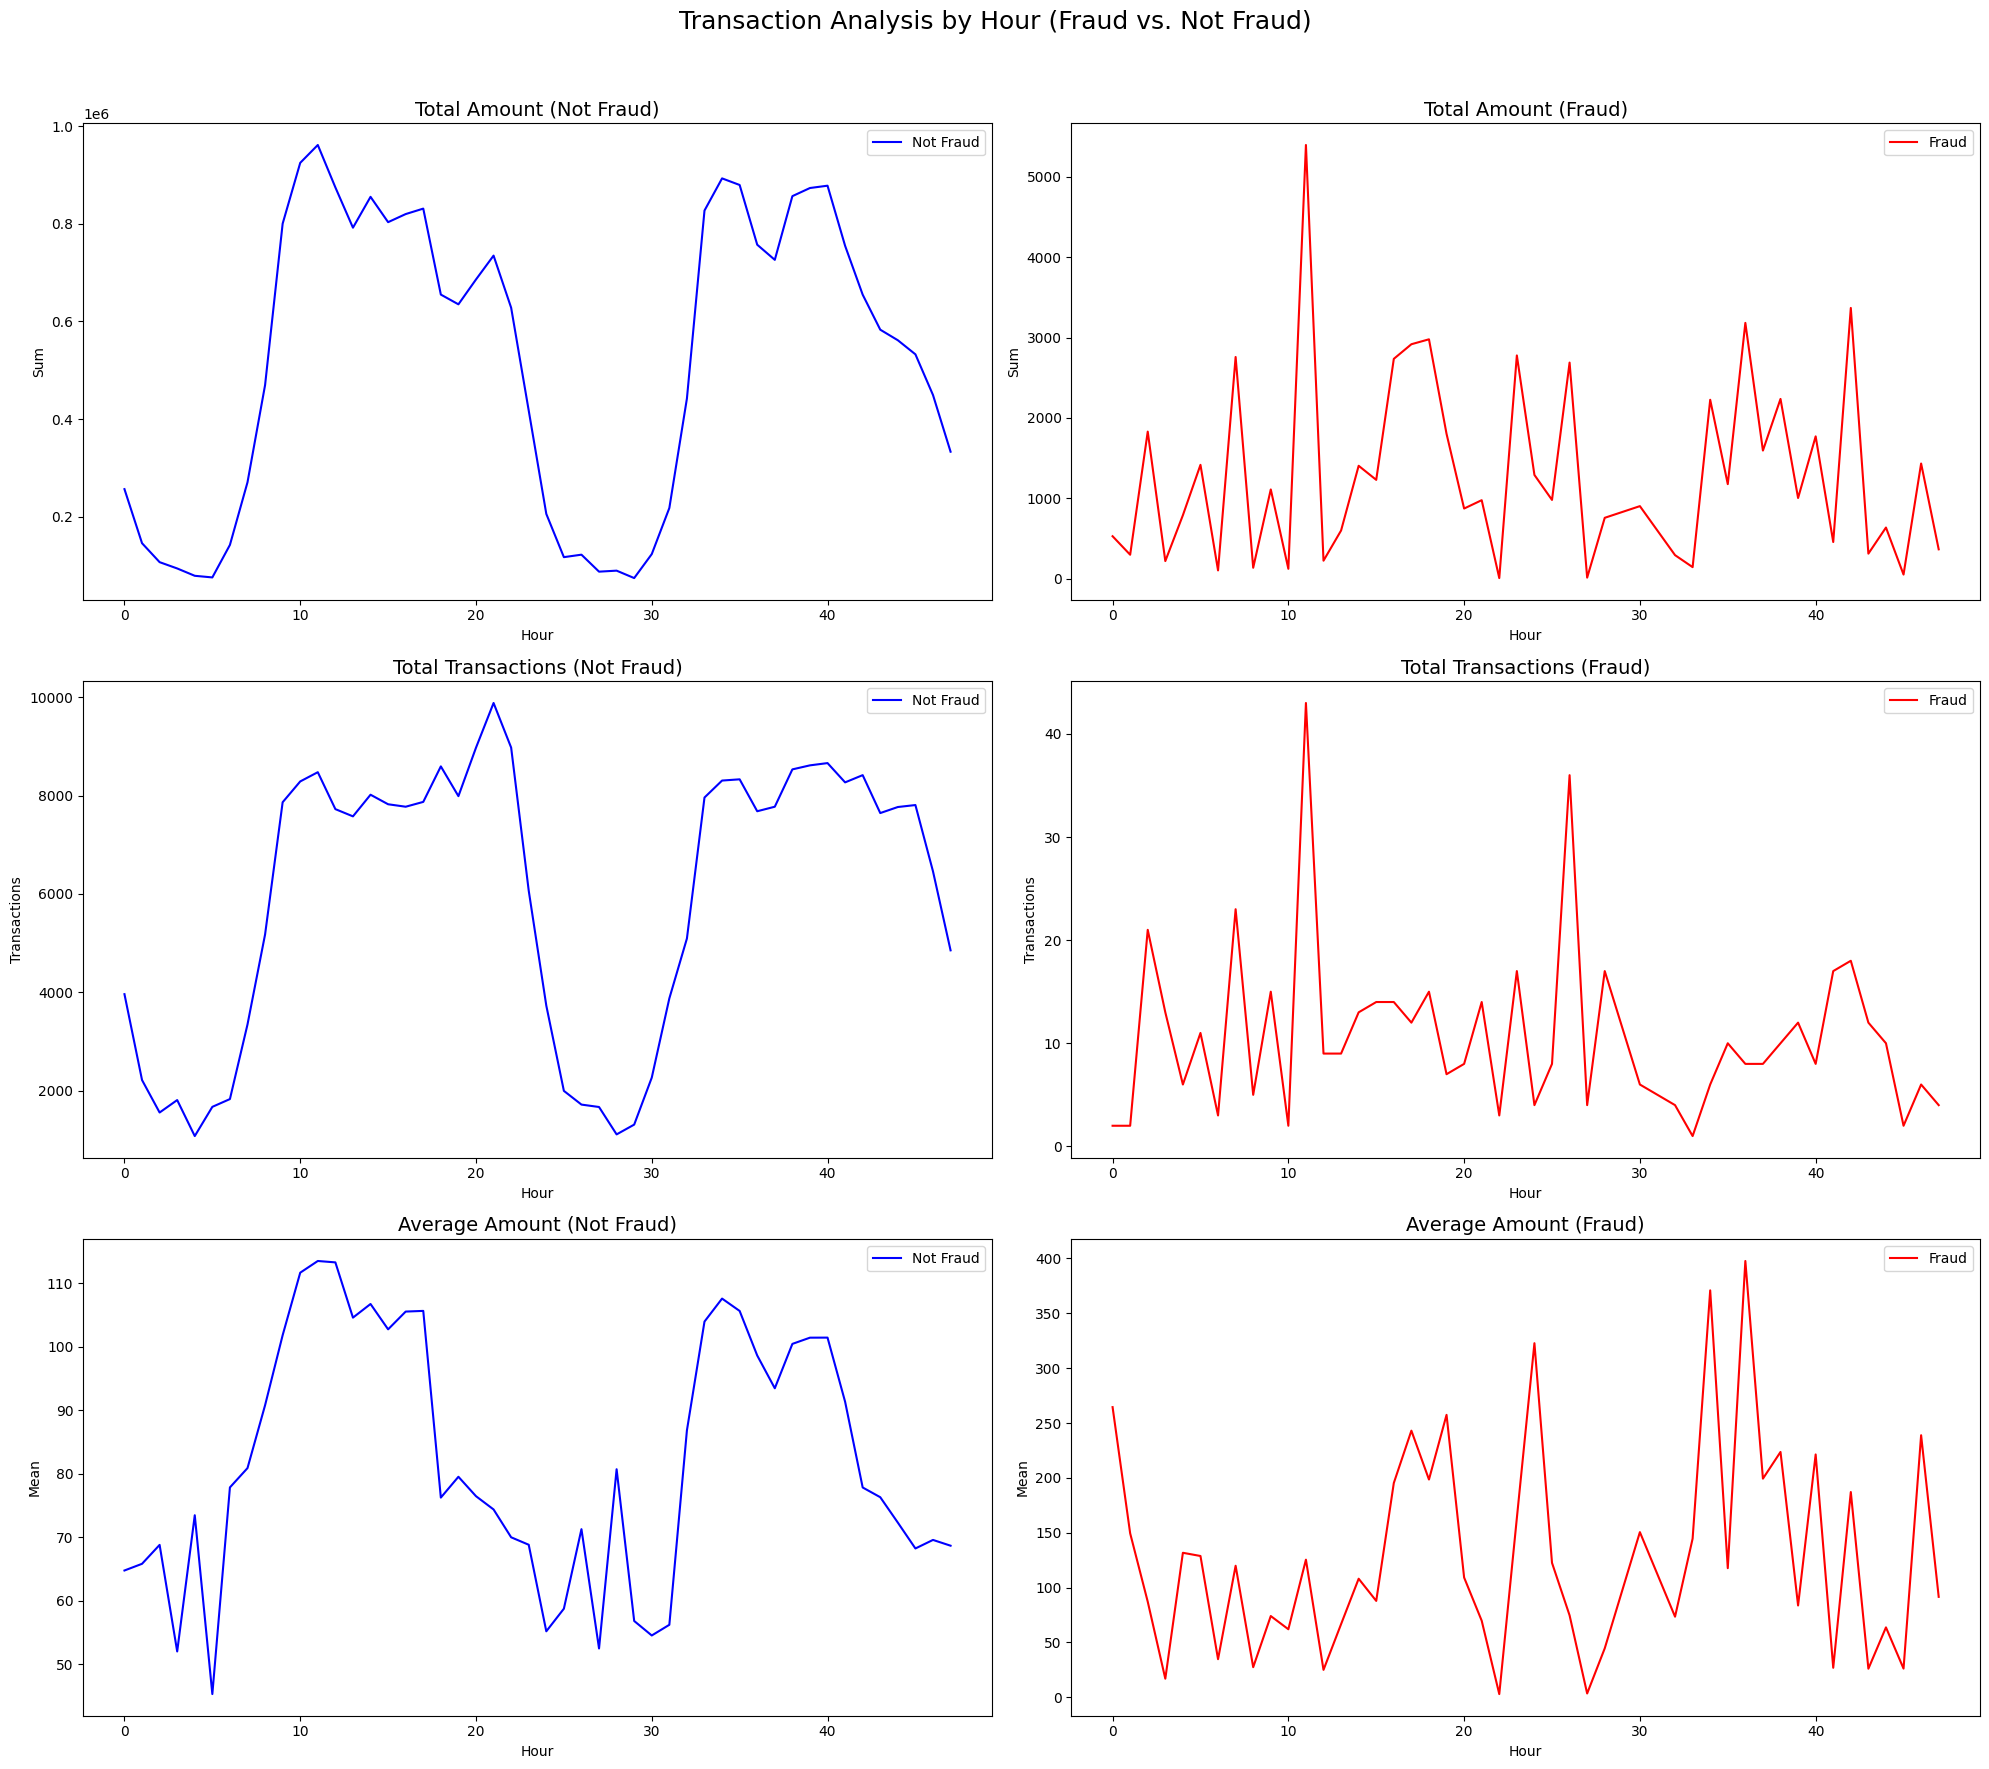

In [69]:
# Lets Explore more about Fraud VS Non-Fraud Transactions

#  Total Transactions, Total Amount, and Average Amount by Hour
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))

# Total Amount
sns.lineplot(ax=axes[0, 0], x="Hour", y="Sum", data=df.loc[df.Class == 0], label="Not Fraud", color="blue")
sns.lineplot(ax=axes[0, 1], x="Hour", y="Sum", data=df.loc[df.Class == 1], label="Fraud", color="red")
axes[0, 0].set_title("Total Amount (Not Fraud)", fontsize=14)
axes[0, 1].set_title("Total Amount (Fraud)", fontsize=14)

# Total Transactions
sns.lineplot(ax=axes[1, 0], x="Hour", y="Transactions", data=df.loc[df.Class == 0], label="Not Fraud", color="blue")
sns.lineplot(ax=axes[1, 1], x="Hour", y="Transactions", data=df.loc[df.Class == 1], label="Fraud", color="red")
axes[1, 0].set_title("Total Transactions (Not Fraud)", fontsize=14)
axes[1, 1].set_title("Total Transactions (Fraud)", fontsize=14)

# Average Amount
sns.lineplot(ax=axes[2, 0], x="Hour", y="Mean", data=df.loc[df.Class == 0], label="Not Fraud", color="blue")
sns.lineplot(ax=axes[2, 1], x="Hour", y="Mean", data=df.loc[df.Class == 1], label="Fraud", color="red")
axes[2, 0].set_title("Average Amount (Not Fraud)", fontsize=14)
axes[2, 1].set_title("Average Amount (Fraud)", fontsize=14)

# Adjust layout for readability
fig.suptitle("Transaction Analysis by Hour (Fraud vs. Not Fraud)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

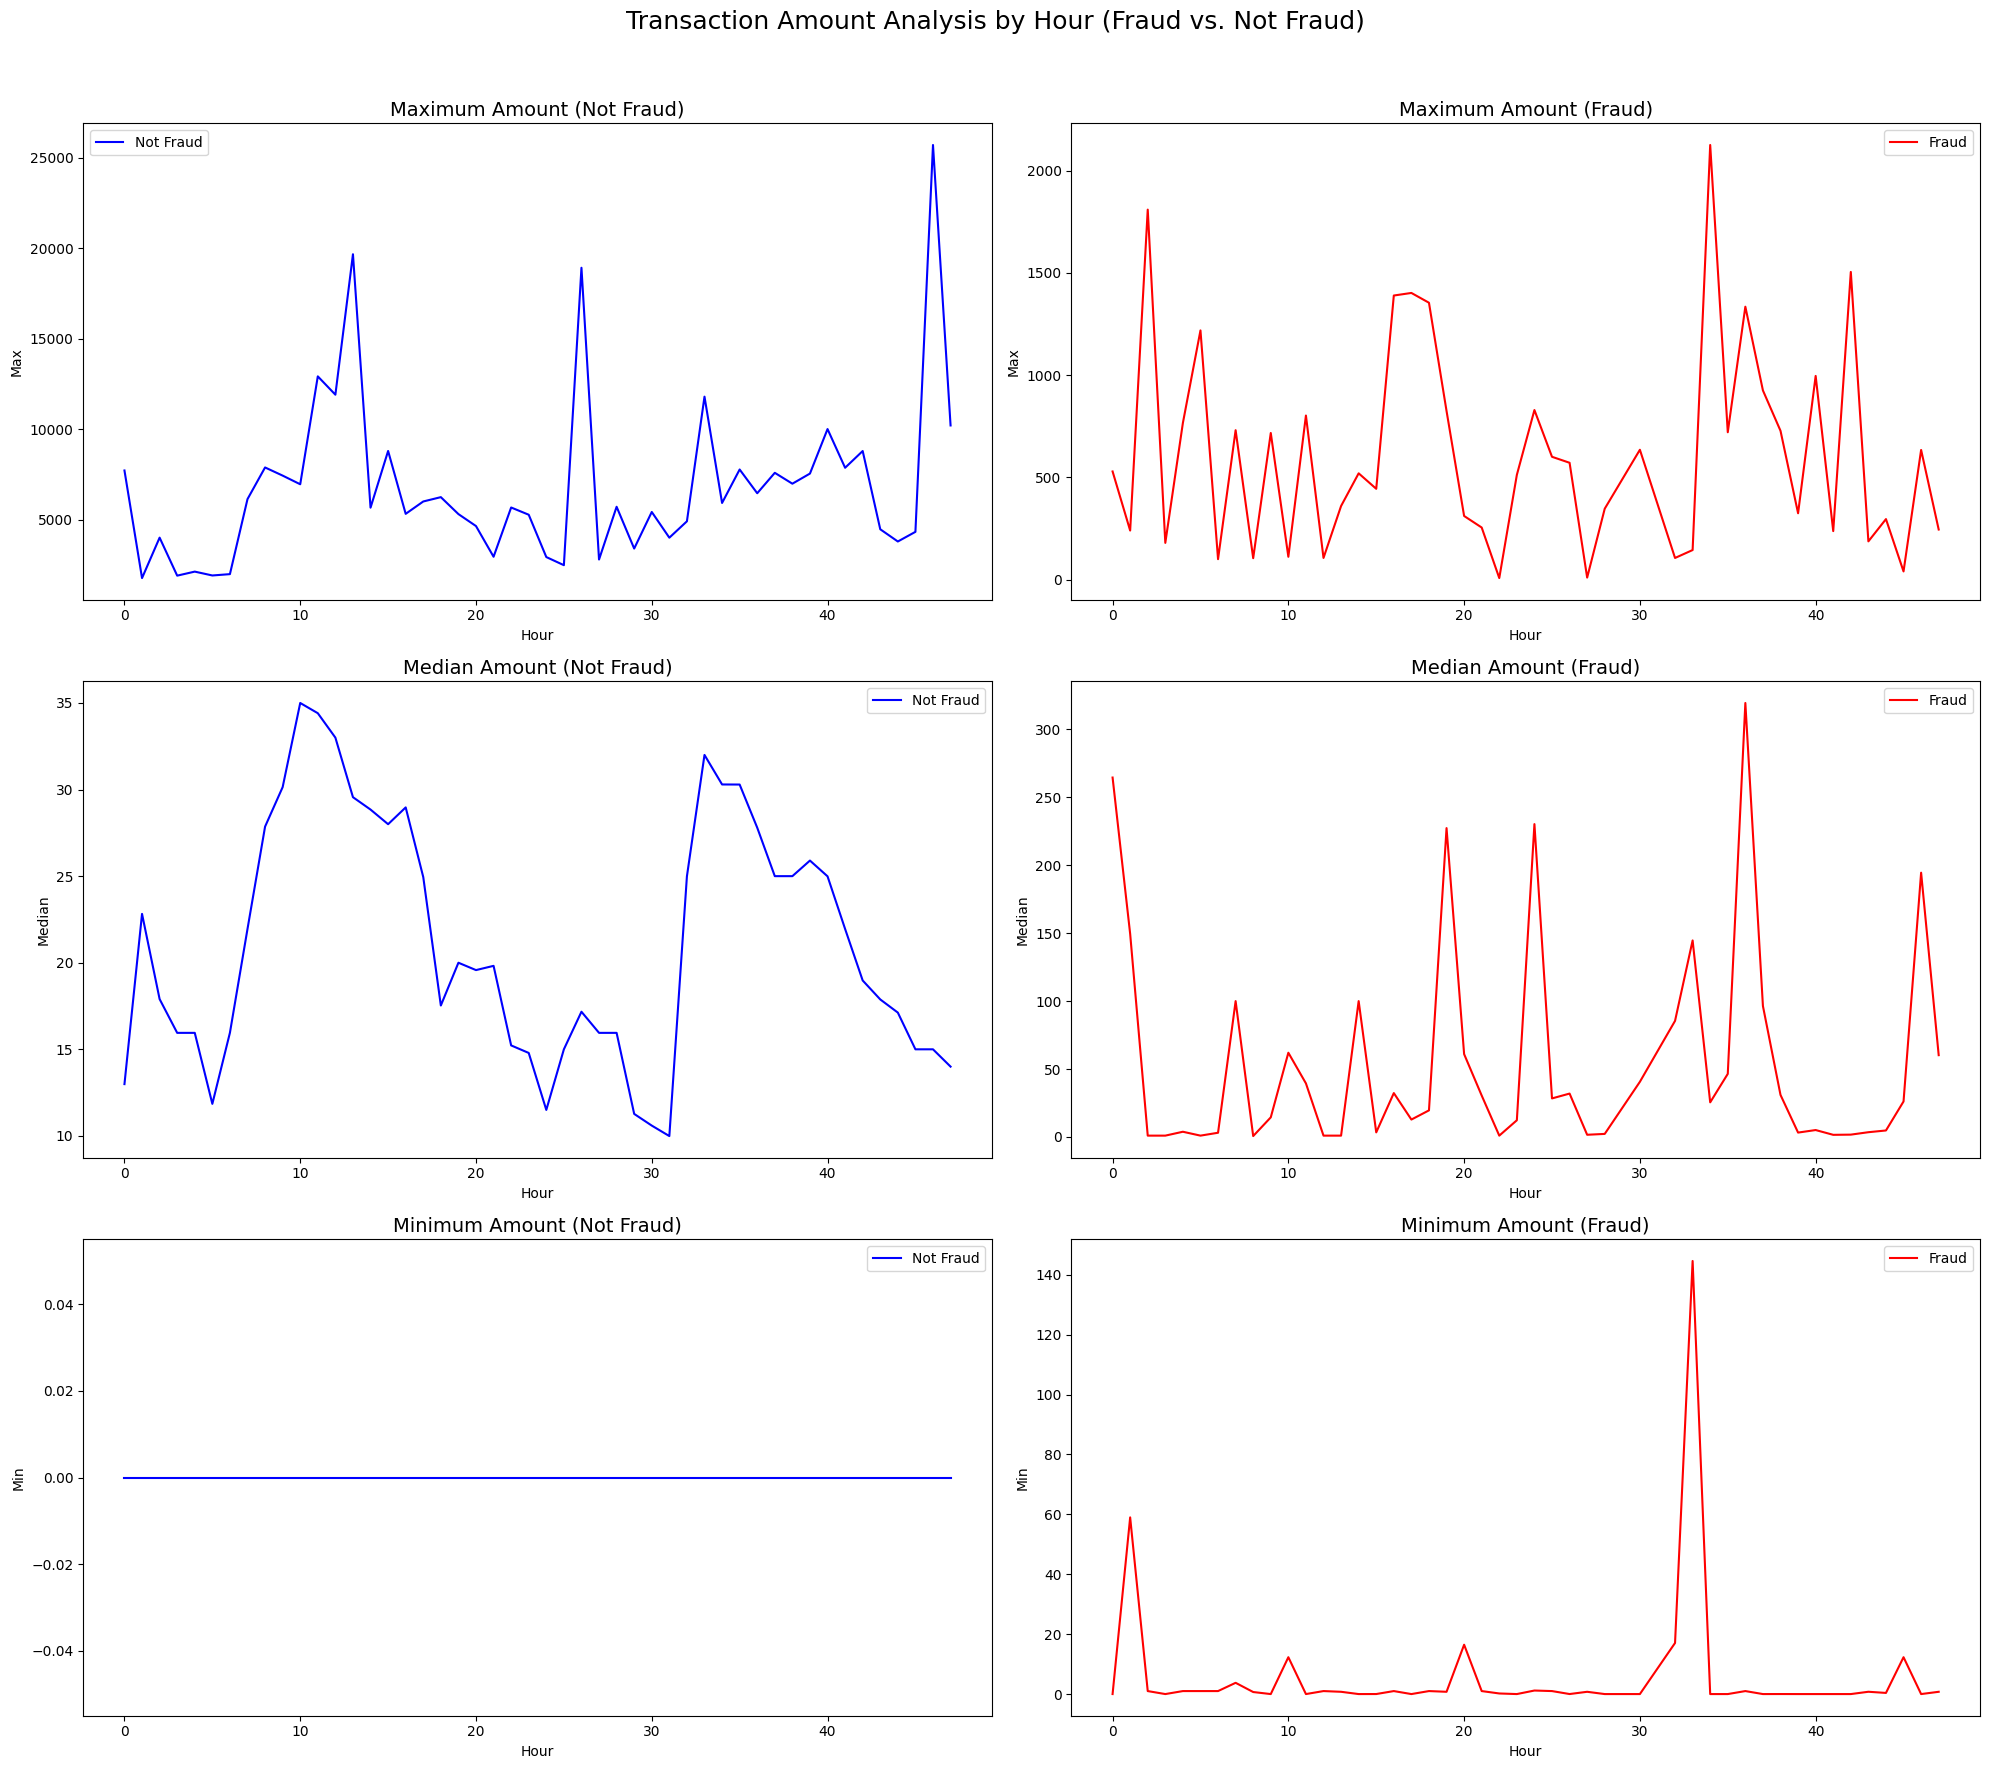

In [70]:
# Maximum, Minimum, and Median Amount by Hour
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))

# Maximum Amount
sns.lineplot(ax=axes[0, 0], x="Hour", y="Max", data=df.loc[df.Class == 0], label="Not Fraud", color="blue")
sns.lineplot(ax=axes[0, 1], x="Hour", y="Max", data=df.loc[df.Class == 1], label="Fraud", color="red")
axes[0, 0].set_title("Maximum Amount (Not Fraud)", fontsize=14)
axes[0, 1].set_title("Maximum Amount (Fraud)", fontsize=14)

# Median Amount
sns.lineplot(ax=axes[1, 0], x="Hour", y="Median", data=df.loc[df.Class == 0], label="Not Fraud", color="blue")
sns.lineplot(ax=axes[1, 1], x="Hour", y="Median", data=df.loc[df.Class == 1], label="Fraud", color="red")
axes[1, 0].set_title("Median Amount (Not Fraud)", fontsize=14)
axes[1, 1].set_title("Median Amount (Fraud)", fontsize=14)

# Minimum Amount
sns.lineplot(ax=axes[2, 0], x="Hour", y="Min", data=df.loc[df.Class == 0], label="Not Fraud", color="blue")
sns.lineplot(ax=axes[2, 1], x="Hour", y="Min", data=df.loc[df.Class == 1], label="Fraud", color="red")
axes[2, 0].set_title("Minimum Amount (Not Fraud)", fontsize=14)
axes[2, 1].set_title("Minimum Amount (Fraud)", fontsize=14)

# Adjust layout for readability
fig.suptitle("Transaction Amount Analysis by Hour (Fraud vs. Not Fraud)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

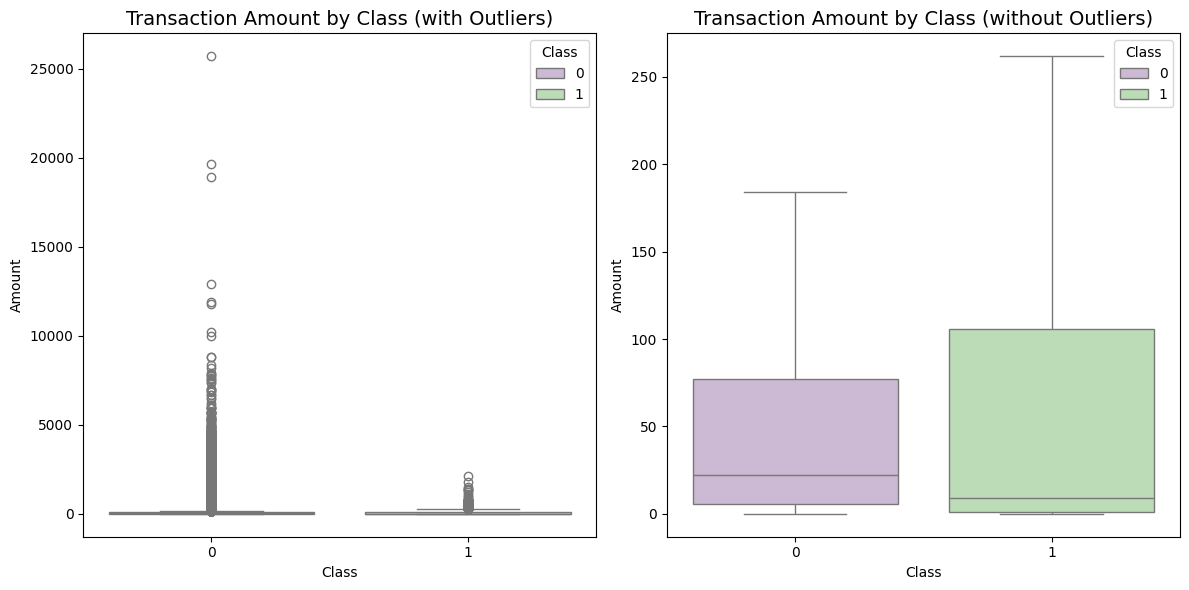

In [71]:
# Boxplots for transaction amounts by class
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Boxplot with outliers
sns.boxplot(ax=ax1, x="Class", y="Amount", hue="Class", data=data_df, palette="PRGn", showfliers=True)
ax1.set_title("Transaction Amount by Class (with Outliers)", fontsize=14)

# Boxplot without outliers
sns.boxplot(ax=ax2, x="Class", y="Amount", hue="Class", data=data_df, palette="PRGn", showfliers=False)
ax2.set_title("Transaction Amount by Class (without Outliers)", fontsize=14)

plt.tight_layout()
plt.show()


In [72]:
# Descriptive statistics for transaction amounts by class
tmp = data_df[['Amount', 'Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']

# Descriptive statistics for non-fraudulent transactions
print("Non-Fraudulent Transactions (Class = 0):")
print(class_0.describe())

# Descriptive statistics for fraudulent transactions
print("\nFraudulent Transactions (Class = 1):")
print(class_1.describe())


Non-Fraudulent Transactions (Class = 0):
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Fraudulent Transactions (Class = 1):
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


## Correlation and Outliers (Data Preprocessing)

These differences suggest that fraudulent transactions tend to have a slightly higher average and median amount but lower maximum outliers compared to non-fraudulent ones. Additionally, non-fraudulent transactions exhibit much larger variability in terms of amount (as indicated by the higher standard deviation and maximum).

Scaling features like `Amount` and `Time` ensures consistent value ranges, reducing the impact of outliers and improving model performance. Removing outliers can further improve model robustness and prevent distortion during training.

To analyze the correlation matrix effectively, we will undersample the non-fraudulent class to create a balanced dataset. This is necessary because the original dataset is highly imbalanced, which can skew correlations and affect their interpretability. By balancing the classes, we ensure that the correlation matrix provides meaningful insights into the relationship between features and fraud.

In [73]:
from sklearn.preprocessing import RobustScaler

# Create a copy of the original dataset
new_df = data_df.copy()

# Scale 'Amount' and 'Time' features
rob_scaler = RobustScaler()
new_df['scaled_amount'] = rob_scaler.fit_transform(new_df['Amount'].values.reshape(-1, 1))
new_df['scaled_time'] = rob_scaler.fit_transform(new_df['Time'].values.reshape(-1, 1))

# Drop original columns and insert scaled columns
new_df.drop(['Time', 'Amount'], axis=1, inplace=True)
new_df.insert(0, 'scaled_amount', new_df.pop('scaled_amount'))
new_df.insert(1, 'scaled_time', new_df.pop('scaled_time'))

In [74]:
# Shuffle data
new_df = new_df.sample(frac=1, random_state=42)

# Create a balanced subsample for correlation analysis
fraud_df = new_df[new_df['Class'] == 1]  # All fraud cases
non_fraud_df = new_df[new_df['Class'] == 0][:len(fraud_df)]  # Match fraud case count

# Combine and shuffle
balanced_df = pd.concat([fraud_df, non_fraud_df]).sample(frac=1, random_state=42)

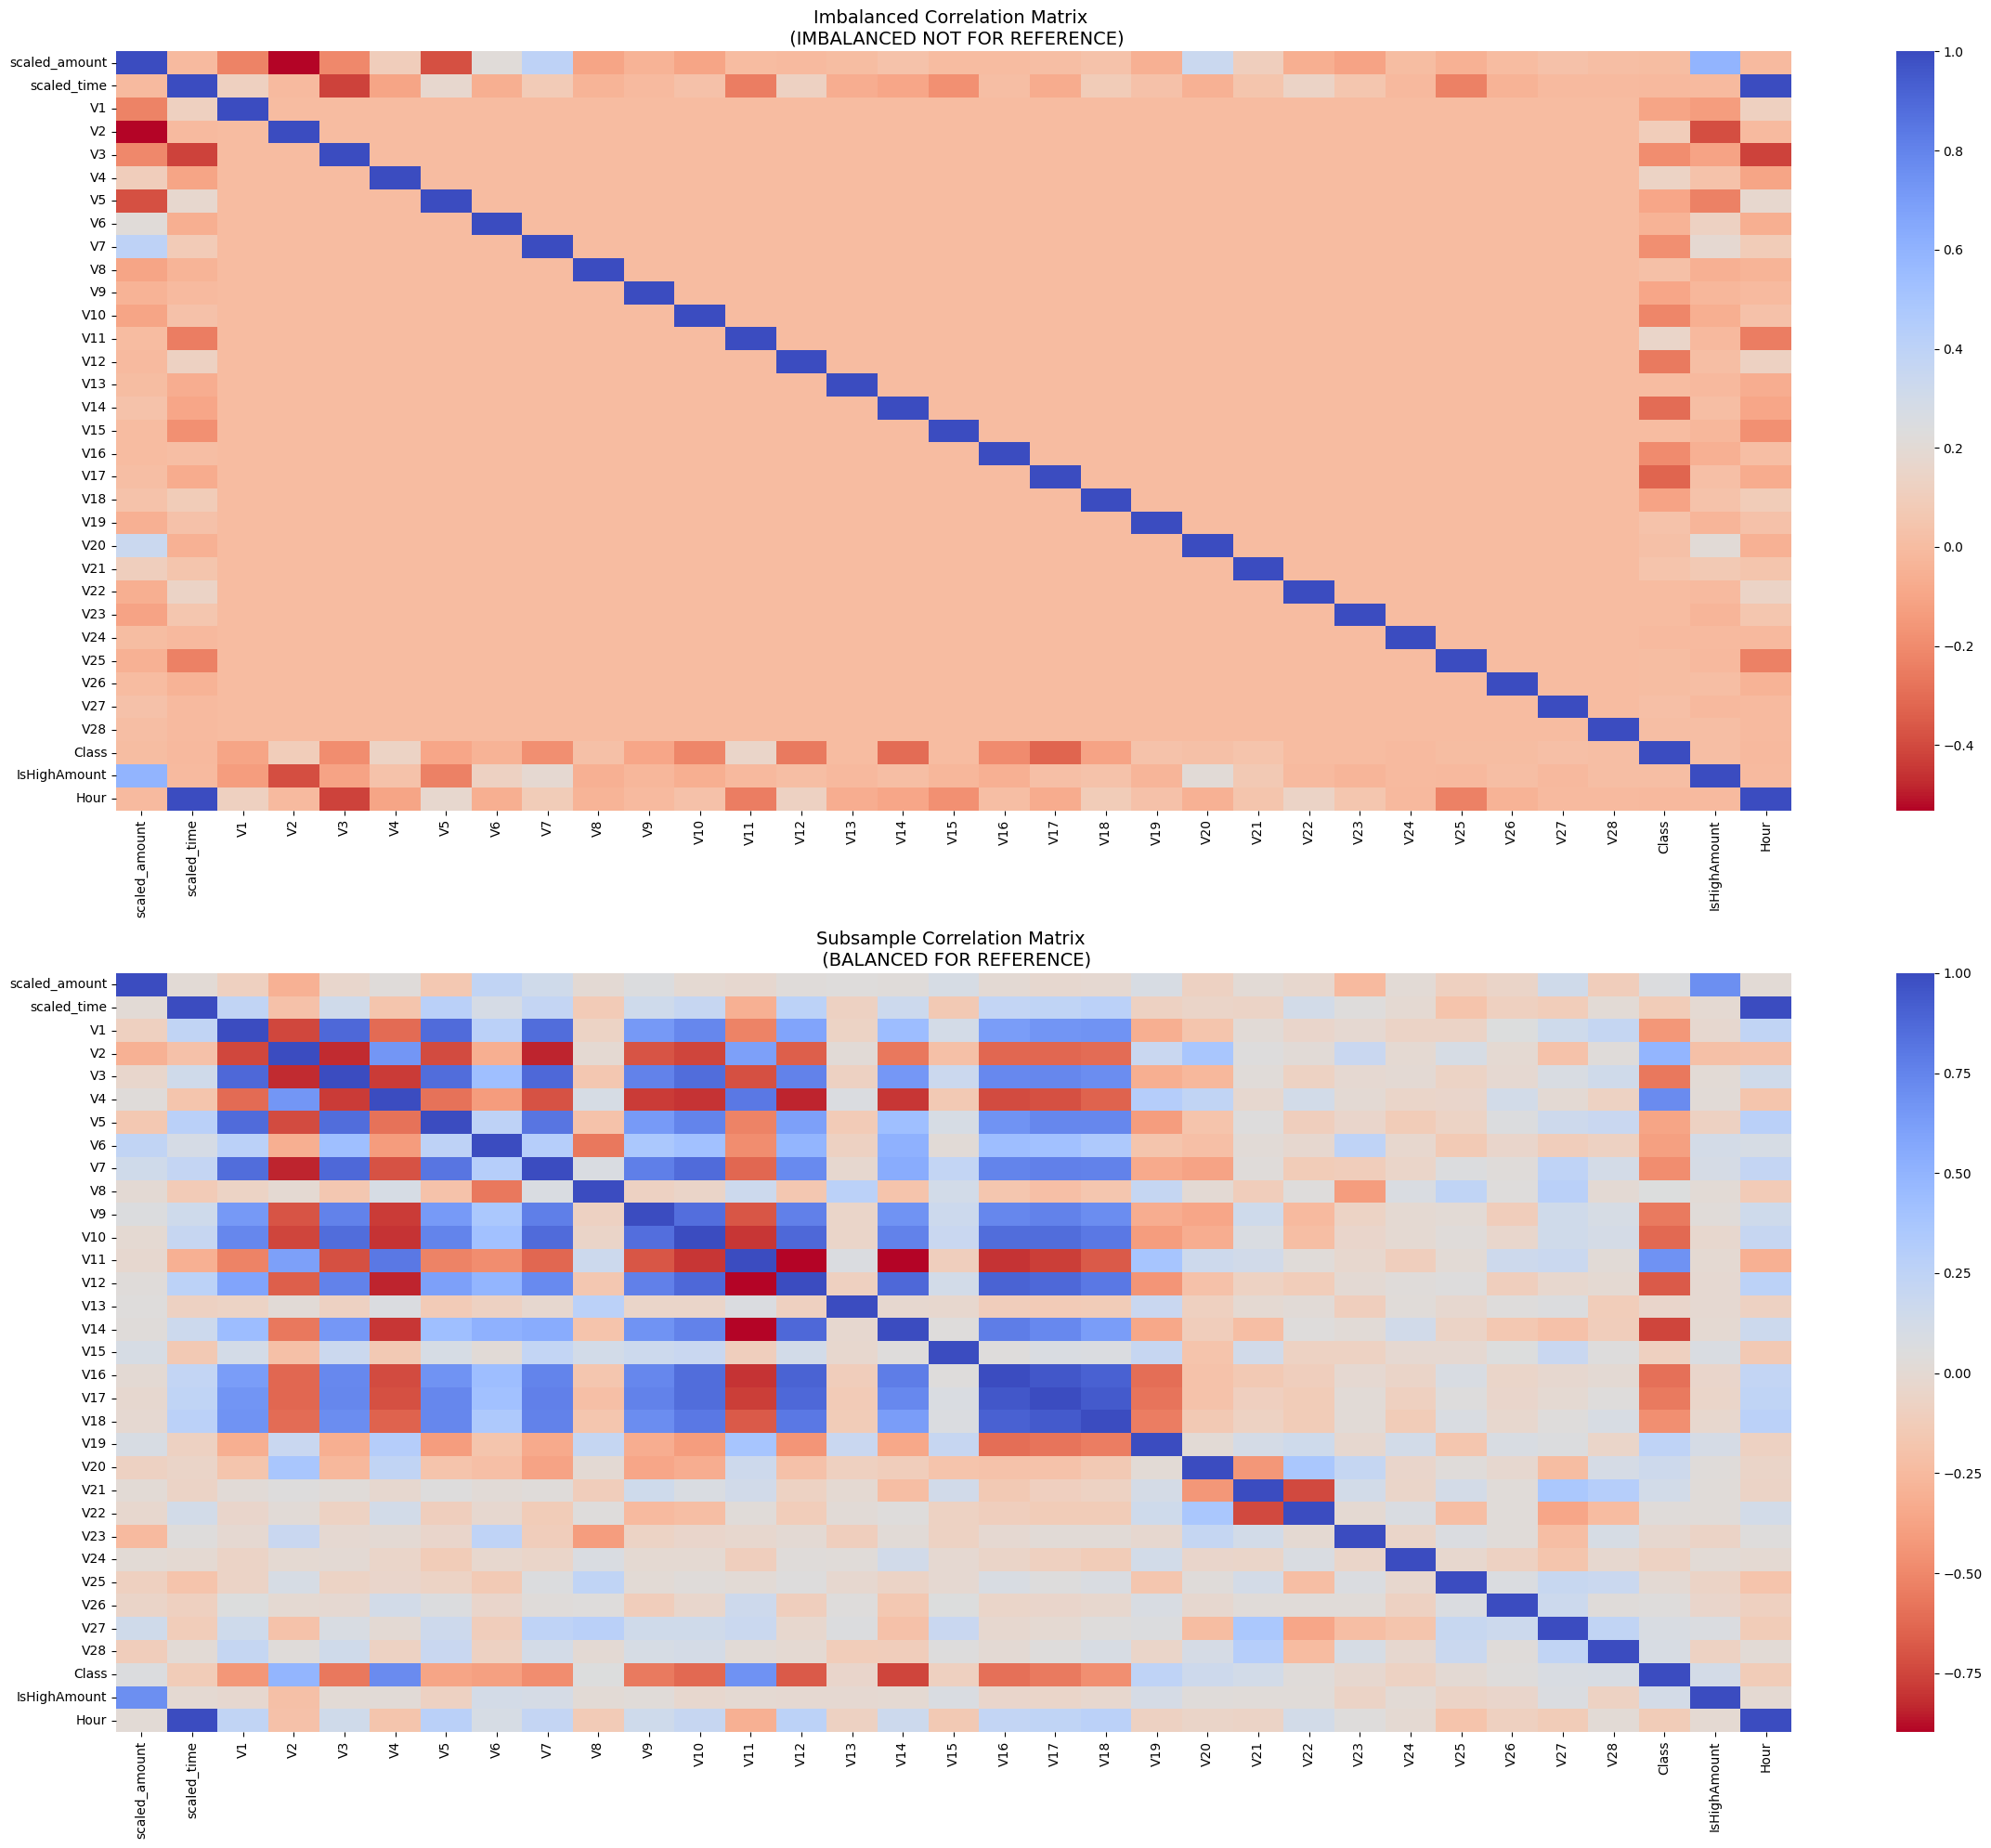

In [75]:
# Plot correlation matrices
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 20))

# Imbalanced correlation matrix
corr = new_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot=False, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (IMBALANCED NOT FOR REFERENCE)", fontsize=14)

# Subsample correlation matrix
sub_corr = balanced_df.corr()
sns.heatmap(sub_corr, cmap='coolwarm_r', annot=False, ax=ax2)
ax2.set_title("Subsample Correlation Matrix \n (BALANCED FOR REFERENCE)", fontsize=14)

plt.tight_layout()
plt.show()

In [76]:
# Calculate correlations with the target variable
correlations = balanced_df.corr()['Class'].sort_values()

# Display top positive and negative correlations
print("Top Negative Correlations:")
print(correlations.head(5))  # Top 5 negative correlations

print("\nTop Positive Correlations:")
print(correlations.tail(5))  # Top 5 positive correlations

Top Negative Correlations:
V14   -0.748671
V12   -0.679680
V10   -0.626376
V16   -0.598676
V3    -0.563496
Name: Class, dtype: float64

Top Positive Correlations:
V19      0.247742
V2       0.490349
V11      0.683459
V4       0.717834
Class    1.000000
Name: Class, dtype: float64


The strongest correlations with fraud show that lower values of `V14`, `V12`, and `V10` are indicative of fraudulent transactions, while higher values of `V4`, `V11`, and `V2` suggest the same.

Outliers in `V14`, `V12`, and `V10` are removed because they have the strongest negative correlations with fraud, making them critical for accurate detection. The **Interquartile Range (IQR)** method will be used to identify and remove extreme values, reducing noise while preserving meaningful data.

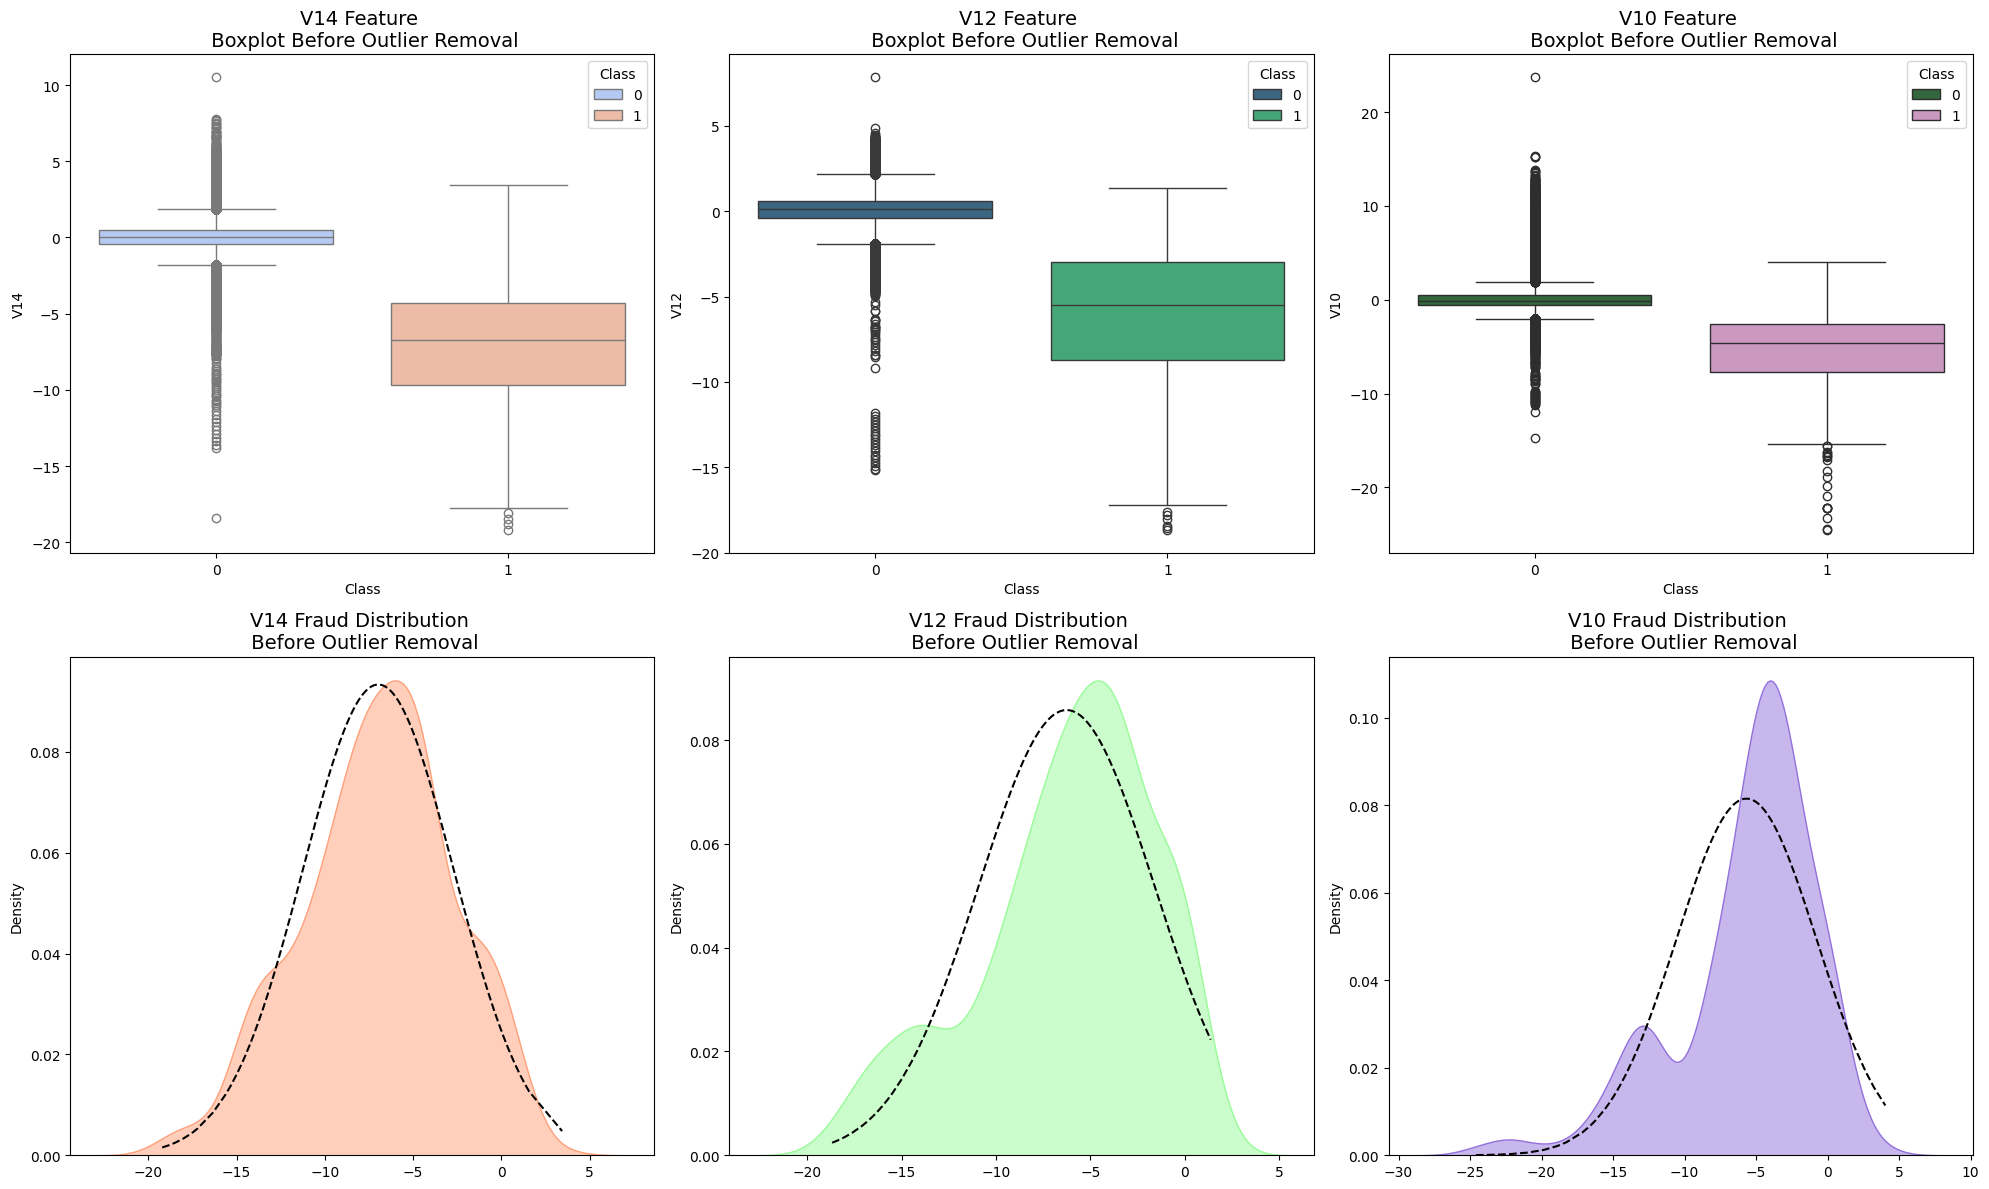

In [77]:
from scipy.stats import norm

# Boxplots and Fraud Distributions BEFORE Outlier Removal
f, axes = plt.subplots(2, 3, figsize=(20, 12))

# --- BOX PLOTS ---
# V14 Boxplot
sns.boxplot(x="Class", y="V14", data=data_df, hue="Class", ax=axes[0, 0], palette="coolwarm", dodge=False)
axes[0, 0].set_title("V14 Feature \n Boxplot Before Outlier Removal", fontsize=14)

# V12 Boxplot
sns.boxplot(x="Class", y="V12", data=data_df, hue="Class", ax=axes[0, 1], palette="viridis", dodge=False)
axes[0, 1].set_title("V12 Feature \n Boxplot Before Outlier Removal", fontsize=14)

# V10 Boxplot
sns.boxplot(x="Class", y="V10", data=data_df, hue="Class", ax=axes[0, 2], palette="cubehelix", dodge=False)
axes[0, 2].set_title("V10 Feature \n Boxplot Before Outlier Removal", fontsize=14)

# --- FRAUD DISTRIBUTIONS ---
# V14 Distribution
v14_fraud_dist = data_df['V14'].loc[data_df['Class'] == 1].values
sns.kdeplot(v14_fraud_dist, ax=axes[1, 0], fill=True, color="#FFA07A", alpha=0.5)
sns.lineplot(
    x=v14_fraud_dist,
    y=norm.pdf(v14_fraud_dist, np.mean(v14_fraud_dist), np.std(v14_fraud_dist)),
    ax=axes[1, 0],
    color="black",
    linestyle="--",
)
axes[1, 0].set_title("V14 Fraud Distribution \n Before Outlier Removal", fontsize=14)

# V12 Distribution
v12_fraud_dist = data_df['V12'].loc[data_df['Class'] == 1].values
sns.kdeplot(v12_fraud_dist, ax=axes[1, 1], fill=True, color="#98FB98", alpha=0.5)
sns.lineplot(
    x=v12_fraud_dist,
    y=norm.pdf(v12_fraud_dist, np.mean(v12_fraud_dist), np.std(v12_fraud_dist)),
    ax=axes[1, 1],
    color="black",
    linestyle="--",
)
axes[1, 1].set_title("V12 Fraud Distribution \n Before Outlier Removal", fontsize=14)

# V10 Distribution
v10_fraud_dist = data_df['V10'].loc[data_df['Class'] == 1].values
sns.kdeplot(v10_fraud_dist, ax=axes[1, 2], fill=True, color="#9370DB", alpha=0.5)
sns.lineplot(
    x=v10_fraud_dist,
    y=norm.pdf(v10_fraud_dist, np.mean(v10_fraud_dist), np.std(v10_fraud_dist)),
    ax=axes[1, 2],
    color="black",
    linestyle="--",
)
axes[1, 2].set_title("V10 Fraud Distribution \n Before Outlier Removal", fontsize=14)

# Adjust layout for readability
plt.tight_layout()
plt.show()


In [78]:
def remove_outliers(dataframe, feature, class_label=1, multiplier=1.5):
    fraud_values = dataframe[feature].loc[dataframe['Class'] == class_label].values
    q25, q75 = np.percentile(fraud_values, 25), np.percentile(fraud_values, 75)
    iqr = q75 - q25
    cut_off = iqr * multiplier
    lower, upper = q25 - cut_off, q75 + cut_off
    
    print(f"Feature: {feature}")
    print(f"Lower Bound: {lower:.2f}, Upper Bound: {upper:.2f}")
    print(f"Number of Outliers: {sum((fraud_values < lower) | (fraud_values > upper))}")
    
    cleaned_df = dataframe.drop(dataframe[(dataframe[feature] > upper) | (dataframe[feature] < lower)].index)
    return cleaned_df

# Removing outliers for V14, V12, and V10
cleaned_df = data_df.copy()
for feature in ['V14', 'V12', 'V10']:
    cleaned_df = remove_outliers(cleaned_df, feature)

Feature: V14
Lower Bound: -17.81, Upper Bound: 3.83
Number of Outliers: 4
Feature: V12
Lower Bound: -17.34, Upper Bound: 5.78
Number of Outliers: 4
Feature: V10
Lower Bound: -14.90, Upper Bound: 4.92
Number of Outliers: 27


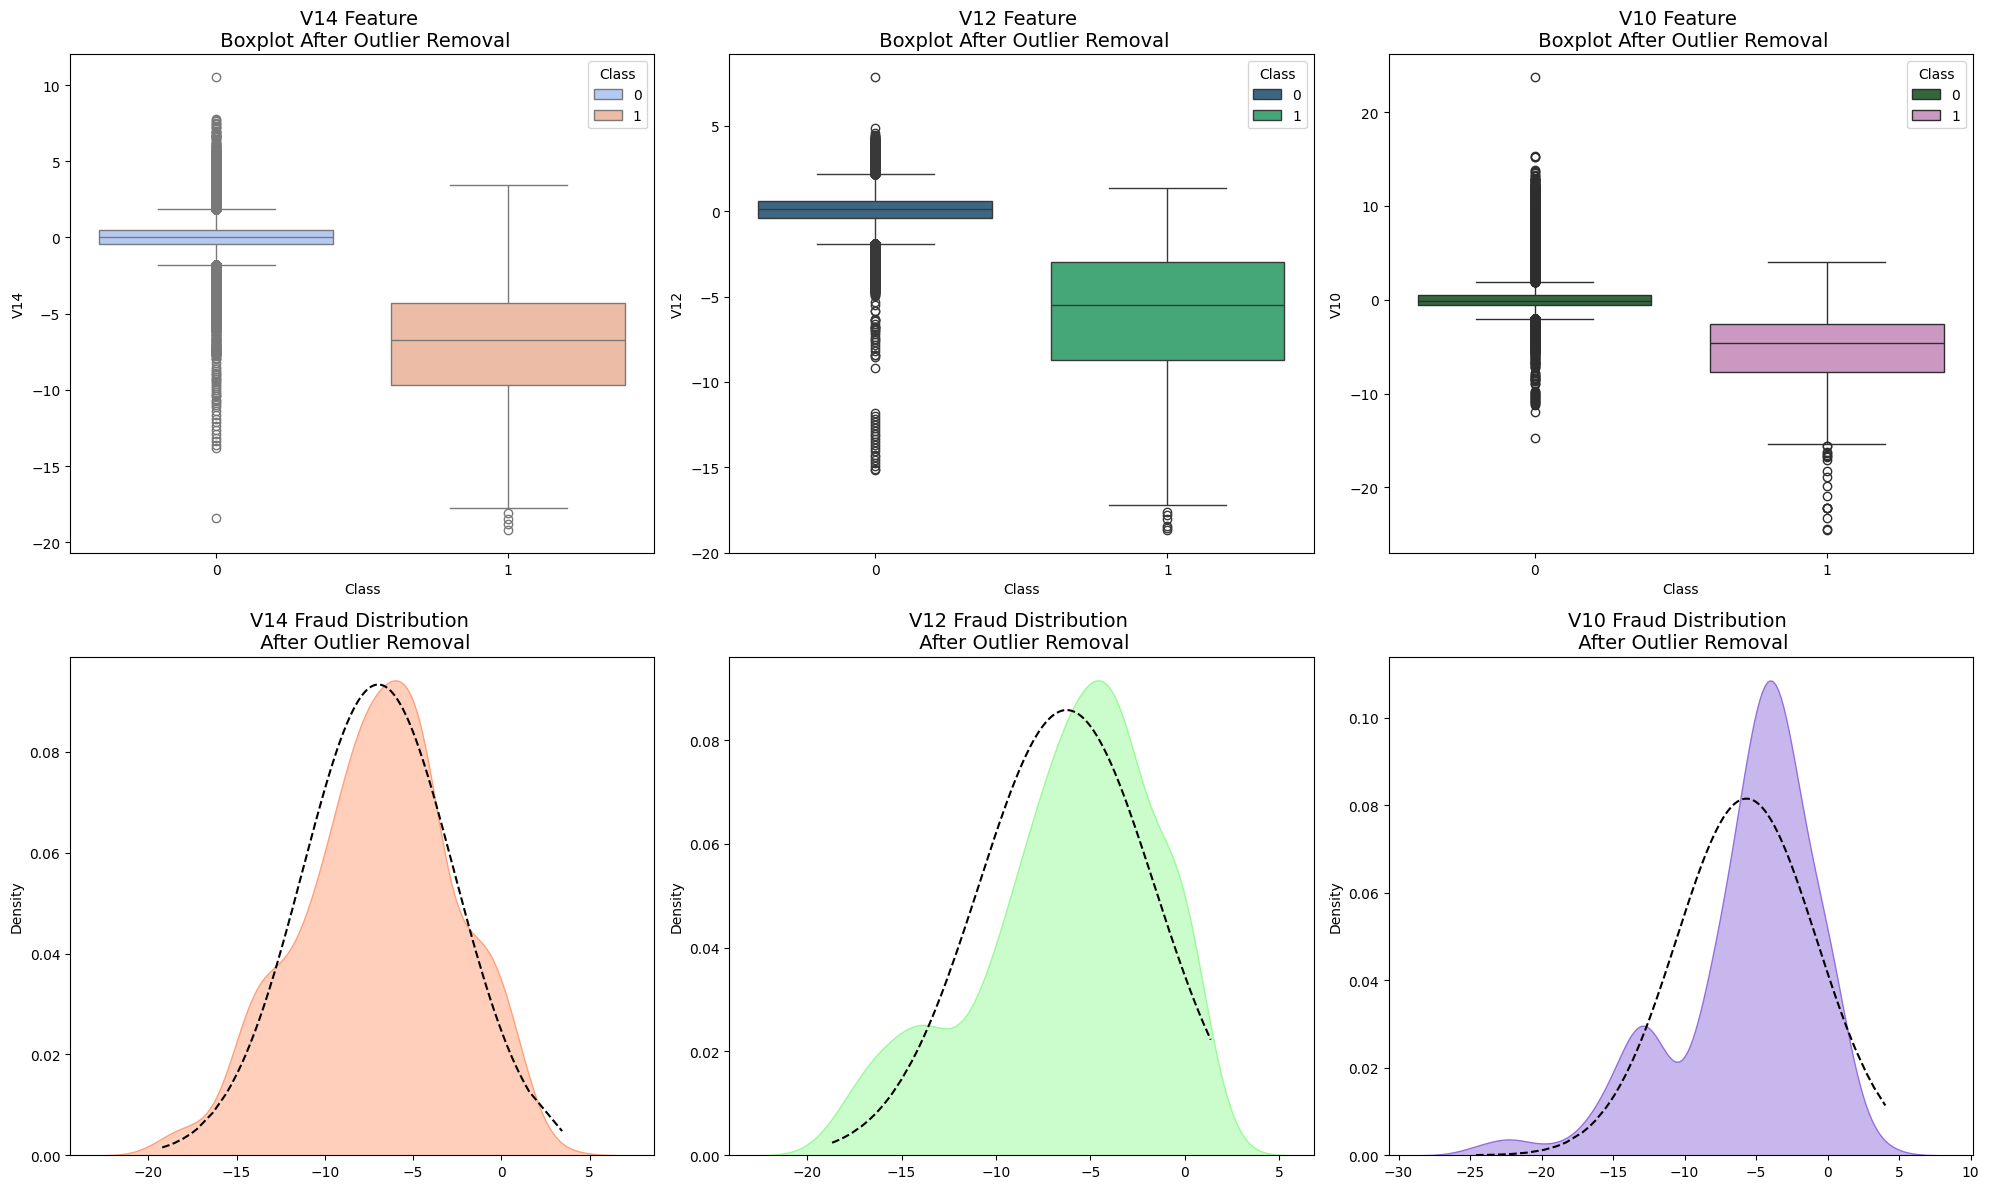

In [79]:
# Boxplots and Fraud Distributions AFTER Outlier Removal
f, axes = plt.subplots(2, 3, figsize=(20, 12))

# --- BOX PLOTS ---
# V14 Boxplot
sns.boxplot(x="Class", y="V14", data=new_df, hue="Class", ax=axes[0, 0], palette="coolwarm", dodge=False)
axes[0, 0].set_title("V14 Feature \n Boxplot After Outlier Removal", fontsize=14)

# V12 Boxplot
sns.boxplot(x="Class", y="V12", data=new_df, hue="Class", ax=axes[0, 1], palette="viridis", dodge=False)
axes[0, 1].set_title("V12 Feature \n Boxplot After Outlier Removal", fontsize=14)

# V10 Boxplot
sns.boxplot(x="Class", y="V10", data=new_df, hue="Class", ax=axes[0, 2], palette="cubehelix", dodge=False)
axes[0, 2].set_title("V10 Feature \n Boxplot After Outlier Removal", fontsize=14)

# --- FRAUD DISTRIBUTIONS ---
# V14 Distribution
v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.kdeplot(v14_fraud_dist, ax=axes[1, 0], fill=True, color="#FFA07A", alpha=0.5)
sns.lineplot(
    x=v14_fraud_dist,
    y=norm.pdf(v14_fraud_dist, np.mean(v14_fraud_dist), np.std(v14_fraud_dist)),
    ax=axes[1, 0],
    color="black",
    linestyle="--",
)
axes[1, 0].set_title("V14 Fraud Distribution \n After Outlier Removal", fontsize=14)

# V12 Distribution
v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.kdeplot(v12_fraud_dist, ax=axes[1, 1], fill=True, color="#98FB98", alpha=0.5)
sns.lineplot(
    x=v12_fraud_dist,
    y=norm.pdf(v12_fraud_dist, np.mean(v12_fraud_dist), np.std(v12_fraud_dist)),
    ax=axes[1, 1],
    color="black",
    linestyle="--",
)
axes[1, 1].set_title("V12 Fraud Distribution \n After Outlier Removal", fontsize=14)

# V10 Distribution
v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.kdeplot(v10_fraud_dist, ax=axes[1, 2], fill=True, color="#9370DB", alpha=0.5)
sns.lineplot(
    x=v10_fraud_dist,
    y=norm.pdf(v10_fraud_dist, np.mean(v10_fraud_dist), np.std(v10_fraud_dist)),
    ax=axes[1, 2],
    color="black",
    linestyle="--",
)
axes[1, 2].set_title("V10 Fraud Distribution \n After Outlier Removal", fontsize=14)

# Adjust layout for readability
plt.tight_layout()
plt.show()

### Outlier Removal Process and Tradeoff

The outlier removal process focused on improving the dataset's quality by eliminating extreme values in the features `V14`, `V12`, and `V10`, which were strongly correlated with fraudulent transactions. The **Interquartile Range (IQR)** method was used to detect outliers, defining them as values outside the range [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]. Adjusting this multiplier controls the sensitivity of outlier detection. For instance, with a multiplier of 1.5, the removal thresholds were [-17.81, 3.83] for `V14`, [-17.34, 5.78] for `V12`, and [-14.90, 4.92] for `V10`, resulting in the removal of 4, 4, and 27 outliers, respectively.

The impact of this process was evident when comparing data before and after outlier removal. Initially, boxplots and distributions revealed significant variability, with extreme values skewing key features. After removing outliers, the data became more compact and representative, particularly for fraudulent transactions. This step reduced noise and enhanced the dataset's suitability for model training while preserving meaningful patterns.

A critical tradeoff in outlier removal is the choice of the threshold multiplier. A lower multiplier (e.g., 1.5) removes more outliers but risks losing valuable information, which may reduce model accuracy. Conversely, a higher multiplier (e.g., 3) focuses on extreme outliers, preserving more data but potentially leaving some subtle outliers in the dataset. Striking the right balance ensures that the data remains clean while retaining the integrity of patterns essential for accurate classification. By focusing on removing only extreme outliers, the process minimized noise without compromising key features necessary for effective model training.

# Class Separability and Model Selection

Dimensionality reduction simplifies high-dimensional data into 2D for visualization, helping us evaluate how well fraudulent and non-fraudulent transactions can be separated. This step provides insights into the dataset's structure and guides preprocessing and model selection.

**Why Dimensionality Reduction?**
- **Simplify Visualization**: Reduces complex data for easier interpretation.
- **Assess Class Patterns**: Highlights whether fraud and non-fraud form distinct clusters or overlap.
- **Guide Modeling**: Clear separability suggests simpler models; overlap may require advanced techniques.

**Techniques Used:**
1. **t-SNE**: Non-linear, focuses on local relationships.
2. **PCA**: Linear, identifies directions of maximum variance.
3. **Truncated SVD**: Linear, efficient for sparse/high-dimensional data.

These methods reveal how well fraud and non-fraud classes separate, aiding feature engineering and model selection.

In [80]:
# Perform dimensionality reduction to visualize class separability
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# Use Balanced Undersampling for dimensionality reduction as the dataset is imbalanced and large
fraud_df = data_df[data_df['Class'] == 1]
non_fraud_df = data_df[data_df['Class'] == 0].sample(len(fraud_df), random_state=42)

# Combine and shuffle
undersampled_df = pd.concat([fraud_df, non_fraud_df]).sample(frac=1, random_state=42)

# Separate features (X) and target (y)
X = undersampled_df.drop('Class', axis=1)
y = undersampled_df['Class']

# Apply t-SNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

# Apply PCA
X_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)

# Apply Truncated SVD
X_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X.values)

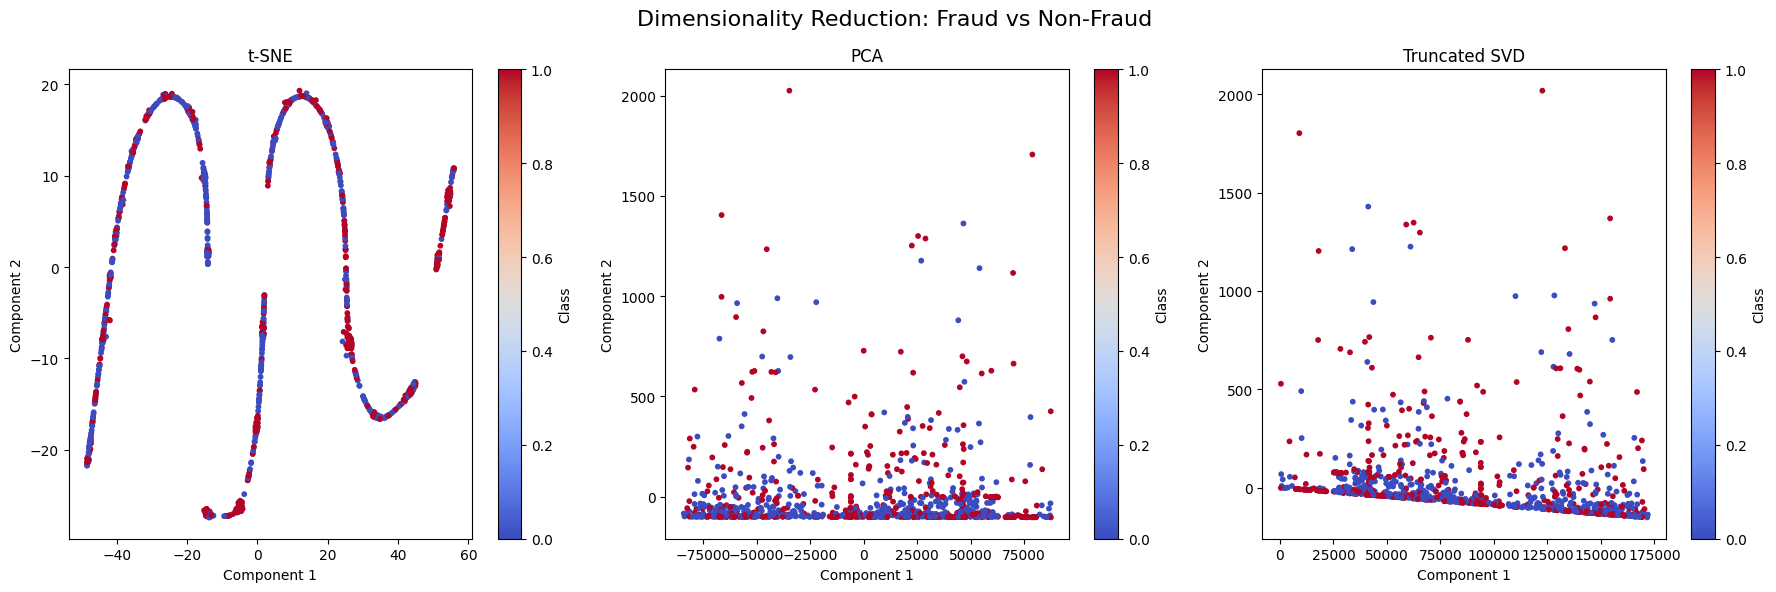

In [81]:
# Create subplots for each dimensionality reduction method
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Dimensionality Reduction: Fraud vs Non-Fraud', fontsize=16)

# t-SNE plot
scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', s=10)
ax1.set_title('t-SNE')
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')

# PCA plot
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', s=10)
ax2.set_title('PCA')
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')

# Truncated SVD plot
scatter3 = ax3.scatter(X_svd[:, 0], X_svd[:, 1], c=y, cmap='coolwarm', s=10)
ax3.set_title('Truncated SVD')
ax3.set_xlabel('Component 1')
ax3.set_ylabel('Component 2')

# Adjust layout and colorbars
plt.colorbar(scatter1, ax=ax1, label='Class')
plt.colorbar(scatter2, ax=ax2, label='Class')
plt.colorbar(scatter3, ax=ax3, label='Class')

plt.tight_layout()
plt.show()

**Observations from Dimensionality Reduction**


The t-SNE visualization shows curved, elongated patterns that likely reflect sequential or temporal relationships in the data. Fraudulent (red) and non-fraudulent (blue) transactions overlap significantly, indicating limited separability in the feature space. PCA and Truncated SVD further highlight this overlap, with both methods showing dense clusters and no clear boundaries between classes.

These findings suggest that the data's inherent structure may not lend itself well to simple classification. Overlap between classes means that a linear approach alone might not suffice, and models capable of capturing non-linear relationships are likely necessary for better fraud detection performance.

To evaluate class separability and predictive performance, I will test:
 - Logistic Regression as a baseline for linear modeling
 - Decision Tree for interpretable, non-linear decision boundaries
 - Random Forest to combine multiple decision trees for improved accuracy and robustness.


## Sampling Techniques: Undersampling and SMOTE

To address the imbalance in the dataset, we use two sampling techniques: **undersampling** and **SMOTE**. These methods help balance the dataset and improve model performance in detecting fraudulent transactions.

**Undersampling** reduces the size of the majority class (non-fraudulent transactions) by randomly selecting a subset that matches the size of the minority class (fraudulent transactions). While it is simple and avoids synthetic data, it can lead to a loss of important patterns in the majority class, which is more impactful for smaller datasets.

**SMOTE (Synthetic Minority Oversampling Technique)**, on the other hand, generates synthetic samples for the minority class by interpolating between data points. This approach retains all majority-class data, making it suitable for smaller datasets, but it risks introducing overfitting if the synthetic data poorly represents real-world patterns.

By applying both methods, we can compare their impact on model performance. Undersampling evaluates how models perform with a reduced dataset, while SMOTE tests their ability to generalize with balanced but augmented data. This dual approach ensures a more comprehensive evaluation of our models.

# Model Implementation

## Logistic Regression Model

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# Drop IsHighAmount to avoid overfitting
X = data_df.drop(['Class', 'IsHighAmount'], axis=1)
y = data_df['Class']

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Undersampling
fraud = X_train[y_train == 1]
non_fraud = X_train[y_train == 0].sample(len(fraud), random_state=42)
X_train_under = pd.concat([fraud, non_fraud])
y_train_under = pd.concat([y_train[y_train == 1], y_train[y_train == 0].sample(len(fraud), random_state=42)])

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Logistic Regression with Undersampling
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.89      0.11       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC AUC Score: 0.9697678010973045


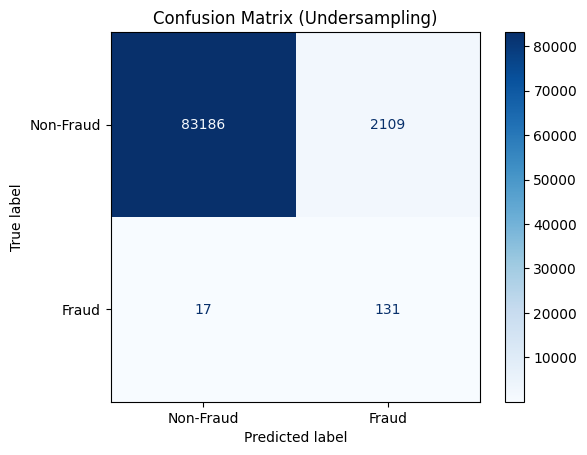

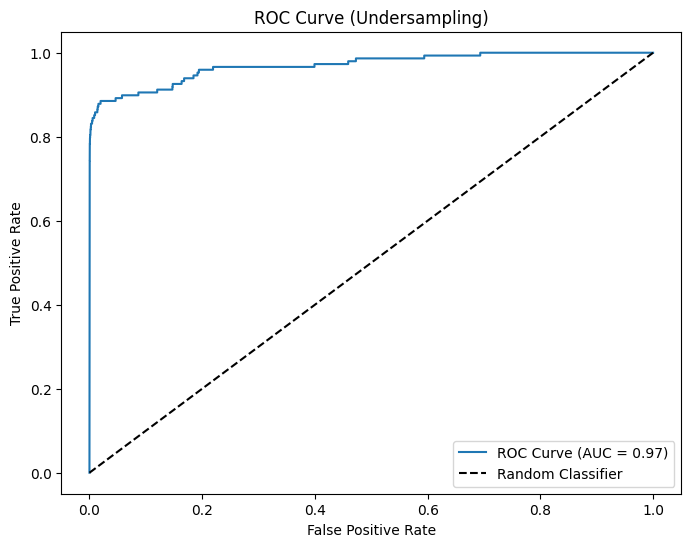

In [89]:
# Train Logistic Regression (Undersampling)
lr_under = LogisticRegression(random_state=42, max_iter=1000)
lr_under.fit(X_train_under, y_train_under)

# Predictions and Evaluation
y_pred_under = lr_under.predict(X_test)
y_pred_prob_under = lr_under.predict_proba(X_test)[:, 1]

# Print Metrics
print("Logistic Regression with Undersampling")
print(classification_report(y_test, y_pred_under))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_under))

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(lr_under, X_test, y_test, cmap='Blues', display_labels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix (Undersampling)")
plt.show()

# Plot ROC Curve
fpr_under, tpr_under, _ = roc_curve(y_test, y_pred_prob_under)
plt.figure(figsize=(8, 6))
plt.plot(fpr_under, tpr_under, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_prob_under)))
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve (Undersampling)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Logistic Regression with SMOTE
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.11      0.85      0.19       148

    accuracy                           0.99     85443
   macro avg       0.55      0.92      0.59     85443
weighted avg       1.00      0.99      0.99     85443

ROC AUC Score: 0.9623640053676984


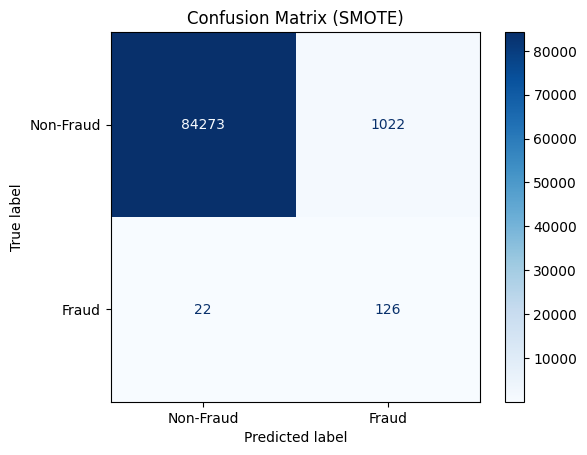

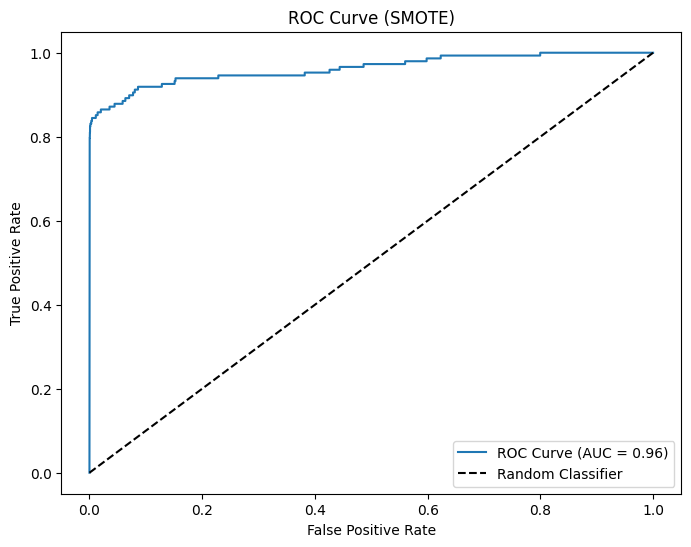

In [90]:
# Train Logistic Regression (SMOTE)
lr_smote = LogisticRegression(random_state=42, max_iter=1000)
lr_smote.fit(X_train_smote, y_train_smote)

# Predictions and Evaluation
y_pred_smote = lr_smote.predict(X_test)
y_pred_prob_smote = lr_smote.predict_proba(X_test)[:, 1]

# Print Metrics
print("\nLogistic Regression with SMOTE")
print(classification_report(y_test, y_pred_smote))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_smote))

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(lr_smote, X_test, y_test, cmap='Blues', display_labels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix (SMOTE)")
plt.show()

# Plot ROC Curve
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_prob_smote)
plt.figure(figsize=(8, 6))
plt.plot(fpr_smote, tpr_smote, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_prob_smote)))
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve (SMOTE)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## Decision Tree Model

Decision Tree with Undersampling
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     85295
           1       0.01      0.89      0.03       148

    accuracy                           0.88     85443
   macro avg       0.51      0.89      0.48     85443
weighted avg       1.00      0.88      0.94     85443

ROC AUC Score: 0.899075743484853


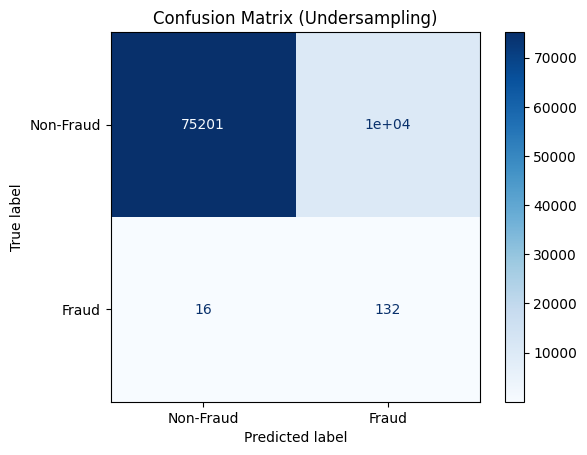

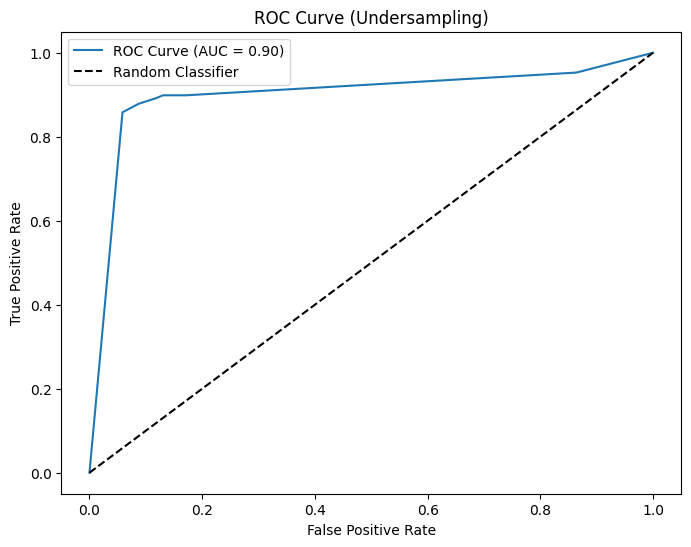

In [91]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree Classifier (Undersampling)
dt_under = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_under.fit(X_train_under, y_train_under)

# Predictions and Evaluation
y_pred_under_dt = dt_under.predict(X_test)
y_pred_prob_under_dt = dt_under.predict_proba(X_test)[:, 1]

# Print Metrics
print("Decision Tree with Undersampling")
print(classification_report(y_test, y_pred_under_dt))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_under_dt))

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(dt_under, X_test, y_test, cmap='Blues', display_labels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix (Undersampling)")
plt.show()

# Plot ROC Curve
fpr_under_dt, tpr_under_dt, _ = roc_curve(y_test, y_pred_prob_under_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr_under_dt, tpr_under_dt, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_prob_under_dt)))
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve (Undersampling)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Decision Tree with SMOTE
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.84      0.11       148

    accuracy                           0.98     85443
   macro avg       0.53      0.91      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC AUC Score: 0.9269387008205227


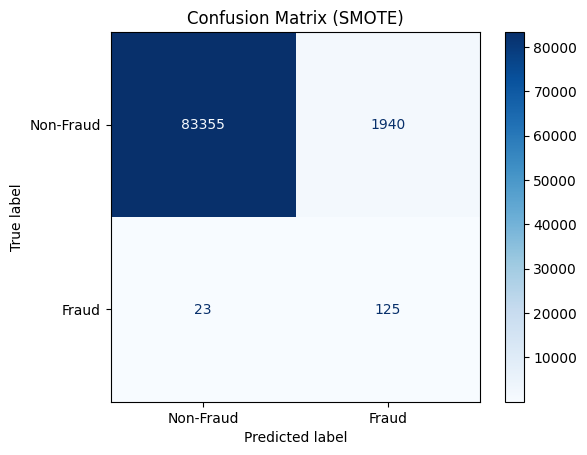

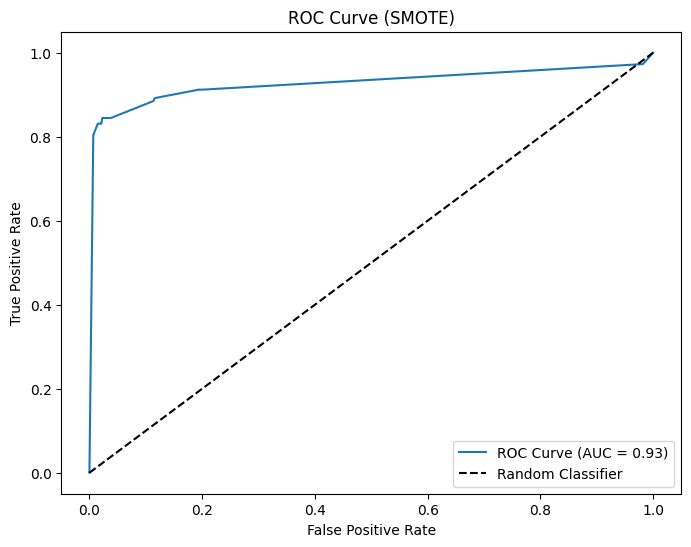

In [92]:
# Train Decision Tree Classifier (SMOTE)
dt_smote = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_smote.fit(X_train_smote, y_train_smote)

# Predictions and Evaluation
y_pred_smote_dt = dt_smote.predict(X_test)
y_pred_prob_smote_dt = dt_smote.predict_proba(X_test)[:, 1]

# Print Metrics
print("\nDecision Tree with SMOTE")
print(classification_report(y_test, y_pred_smote_dt))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_smote_dt))

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(dt_smote, X_test, y_test, cmap='Blues', display_labels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix (SMOTE)")
plt.show()

# Plot ROC Curve
fpr_smote_dt, tpr_smote_dt, _ = roc_curve(y_test, y_pred_prob_smote_dt)
plt.figure(figsize=(8, 6))
plt.plot(fpr_smote_dt, tpr_smote_dt, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_prob_smote_dt)))
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve (SMOTE)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Random Forest Model

Random Forest with Undersampling
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.08      0.86      0.14       148

    accuracy                           0.98     85443
   macro avg       0.54      0.92      0.57     85443
weighted avg       1.00      0.98      0.99     85443

ROC AUC Score: 0.9738044275590438


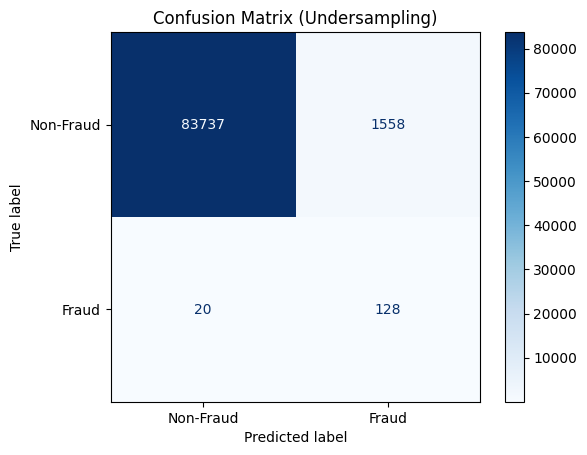

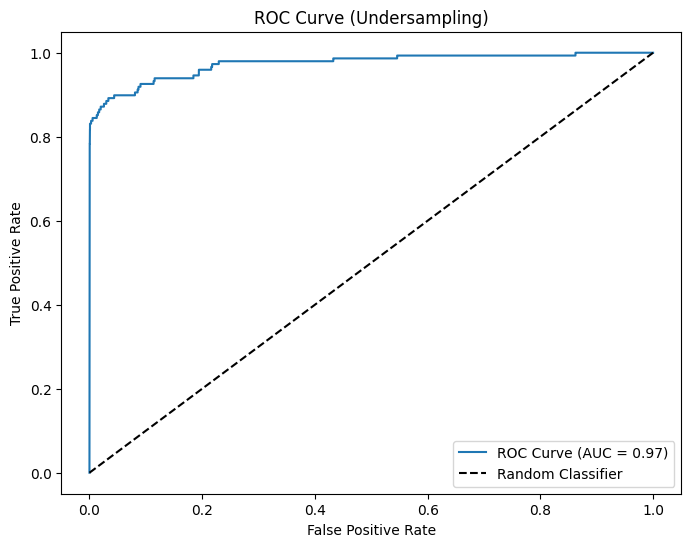

In [93]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier (Undersampling)
rf_under = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_under.fit(X_train_under, y_train_under)

# Predictions and Evaluation
y_pred_under_rf = rf_under.predict(X_test)
y_pred_prob_under_rf = rf_under.predict_proba(X_test)[:, 1]

# Print Metrics
print("Random Forest with Undersampling")
print(classification_report(y_test, y_pred_under_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_under_rf))

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_under, X_test, y_test, cmap='Blues', display_labels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix (Undersampling)")
plt.show()

# Plot ROC Curve
fpr_under_rf, tpr_under_rf, _ = roc_curve(y_test, y_pred_prob_under_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_under_rf, tpr_under_rf, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_prob_under_rf)))
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve (Undersampling)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Random Forest with SMOTE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.58      0.84      0.69       148

    accuracy                           1.00     85443
   macro avg       0.79      0.92      0.84     85443
weighted avg       1.00      1.00      1.00     85443

ROC AUC Score: 0.9734730656560776


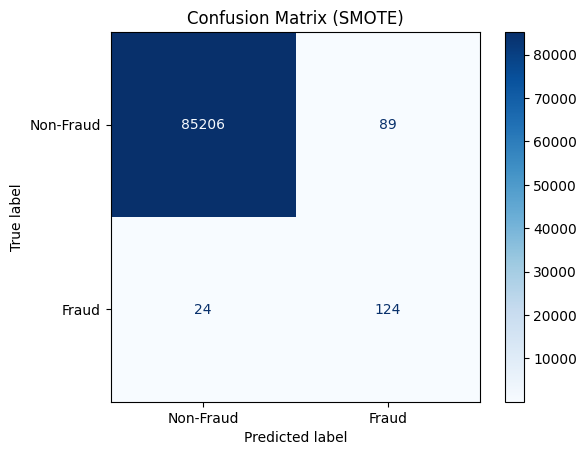

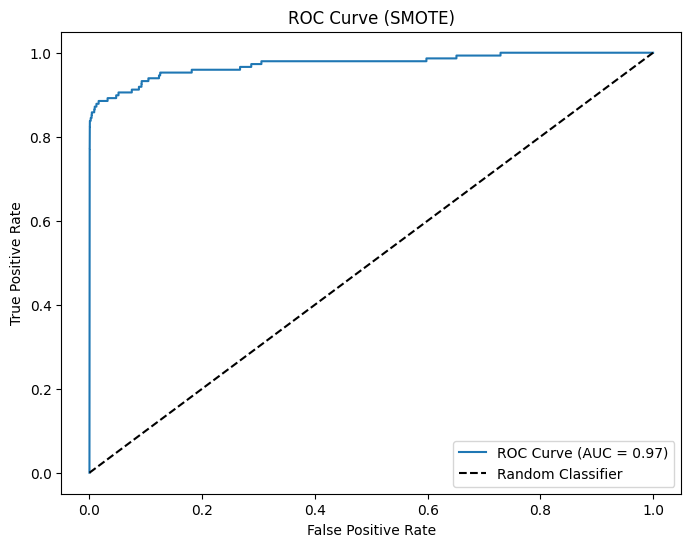

In [94]:
# Train Random Forest Classifier (SMOTE)
rf_smote = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_smote.fit(X_train_smote, y_train_smote)

# Predictions and Evaluation
y_pred_smote_rf = rf_smote.predict(X_test)
y_pred_prob_smote_rf = rf_smote.predict_proba(X_test)[:, 1]

# Print Metrics
print("\nRandom Forest with SMOTE")
print(classification_report(y_test, y_pred_smote_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_smote_rf))

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf_smote, X_test, y_test, cmap='Blues', display_labels=['Non-Fraud', 'Fraud'])
plt.title("Confusion Matrix (SMOTE)")
plt.show()

# Plot ROC Curve
fpr_smote_rf, tpr_smote_rf, _ = roc_curve(y_test, y_pred_prob_smote_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_smote_rf, tpr_smote_rf, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_prob_smote_rf)))
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve (SMOTE)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# Model Comparison and Evaluation

### Logistic Regression
The Logistic Regression model served as a baseline for evaluating linear modeling in detecting fraudulent transactions. Its simplicity and interpretability make it a popular choice for addressing binary classification problems. The model was evaluated using both undersampling and SMOTE techniques to mitigate the inherent class imbalance of the dataset.

Using **undersampling**, the model achieved a high AUC of **0.97**, indicating strong overall performance. The recall for fraudulent transactions was robust, identifying **131 out of 148 cases**, but the model generated **2,109 false positives**, misclassifying non-fraudulent transactions as fraudulent. While the model generalized well with undersampled data, the reduction in precision for fraud detection was notable due to the limited representation of the majority class.

With **SMOTE**, the AUC decreased slightly to **0.96**, but the model achieved a better balance between recall and false negatives. It successfully detected **126 fraudulent transactions** while reducing the number of false negatives to **22**. However, this improvement came at the cost of more false positives, with **1,022 cases** of non-fraudulent transactions being flagged as fraudulent. SMOTE improved the model’s ability to learn representative decision boundaries, offering a better balance of precision and recall compared to undersampling.

**Overall, Logistic Regression provides a strong and interpretable baseline model, excelling in simplicity and speed. However, it is more prone to false positives, especially with SMOTE, and is best suited when interpretability is a priority.**

---

### Decision Tree
Decision Trees are inherently interpretable models capable of capturing non-linear relationships. For this project, the Decision Tree model was also evaluated with undersampling and SMOTE.

With **undersampling**, the model showed decent recall, detecting **132 fraudulent transactions**. However, it misclassified over **10,000 non-fraudulent transactions** as fraudulent, leading to a significant false positive rate. This result highlights the model's limited capacity to handle imbalanced datasets effectively. Additionally, the AUC for this configuration was lower than that of Logistic Regression, reflecting weaker discriminatory power.

Using **SMOTE**, the model did not demonstrate significant improvement over undersampling. While recall remained consistent, the high false positive rate persisted. These findings suggest that Decision Trees, when used in isolation, lack the robustness necessary for imbalanced classification tasks like fraud detection.

**In summary, Decision Trees offer easy interpretability but suffer from high false positive rates and overfitting. They are not recommended as standalone models for highly imbalanced datasets but may perform better as part of an ensemble method.**

---

### Random Forest
Random Forest, an ensemble method aggregating multiple Decision Trees, demonstrated the best performance among all evaluated models. This algorithm excels in robustness and its ability to handle imbalanced datasets effectively.

With **undersampling**, Random Forest achieved an impressive AUC of **0.97**, matching Logistic Regression. The model detected **128 fraudulent transactions** while reducing false positives to **1,558**, a significant improvement over the standalone Decision Tree. Random Forest balanced recall and precision effectively, providing consistent and reliable predictions.

With **SMOTE**, the model maintained a high AUC of **0.97**, showcasing its robustness. It identified **124 fraudulent transactions** while further reducing false positives to just **89 cases**. The use of SMOTE allowed Random Forest to capture more diverse patterns in the data, resulting in superior precision and recall metrics. This configuration demonstrated the model’s ability to generalize effectively without overfitting.

**Overall, Random Forest is the most reliable model for this task, offering high precision, recall, and low false positive rates. It is the best choice for operational fraud detection scenarios where minimizing both false negatives and positives is critical.**

---

### Final Recommendation
Based on the evaluation, **Random Forest with SMOTE** emerges as the optimal model for fraud detection, offering the best balance between recall, precision, and robustness against class imbalance. **Logistic Regression with SMOTE** is a strong alternative, particularly when model interpretability and computational efficiency are important. **Decision Trees**, while interpretable, are not recommended as standalone models due to their high false positive rates and limited robustness.

# Conclusion

Our project addressed the research question: **"How can sampling techniques and machine learning models improve fraud detection in highly imbalanced datasets?"** Through a comprehensive exploration of sampling methods, machine learning models, and data visualization, we found that combining thoughtful preprocessing with robust models can significantly enhance fraud detection performance.

### Key Findings:  
- **Sampling Techniques**:  
  - **Undersampling** effectively reduced class imbalance but led to information loss by discarding non-fraudulent transactions. Despite this, it yielded reasonable performance in terms of recall and precision.  
  - **SMOTE** generated synthetic fraudulent samples to balance the dataset, resulting in more robust models that preserved the original dataset’s information. Models trained on SMOTE-balanced data consistently achieved higher recall rates, indicating better fraud detection capability.  

- **Model Performance**:  
  - **Logistic Regression** served as a reliable baseline but struggled with the non-linear relationships in the dataset.  
  - **Decision Trees** improved interpretability while capturing non-linear patterns, but they occasionally overfit the training data.  
  - **Random Forests** outperformed the other models, leveraging ensemble learning to deliver the highest ROC-AUC scores. This model was particularly effective when paired with SMOTE, achieving a balance between precision and recall.  

### Answer to the Research Question:  
Sampling techniques like **SMOTE** and machine learning models such as **Random Forests** significantly improve fraud detection in highly imbalanced datasets. Sampling techniques address the imbalance challenge by ensuring that the models receive enough fraudulent examples to learn effectively. Machine learning models, especially ensemble methods, capitalize on these balanced datasets to detect anomalies with higher accuracy.  

### Final Thoughts:  
This project demonstrated the importance of balancing datasets and choosing appropriate models for fraud detection. By combining data preprocessing, sampling techniques, and machine learning, we developed a workflow that highlights the potential for advanced analytics in financial data. Future work could explore additional models, such as gradient boosting methods, and incorporate cost-sensitive learning to further enhance real-world applicability.
